In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun AUG 13 18:12:03 2017
trace analysis
of 黄山风景区
@author: noname
"""


import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import matplotlib.pyplot as plt
import os,sys
import time
import scipy.stats as stats
import seaborn.apionly as sns
import statsmodels.api as sm
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

%matplotlib notebook
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['legend.frameon'] = False
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', 
          u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

In [2]:
folder='F:/Research/Huangshan'


device=['H3C', 'Aruba', 'TP-LINK', 'D-Link', 'Intel', 'Hon Hai', 'Cisco', 'AzureWave', 'Liteon', 
        'SYNTECH (HK)', 'Tenda', 'Jing Ren', 'Wistron', 'Doukan', 'InPro', 'Net Com', 'Bilian', 'EASY3CALL',
        'Lemobile', 'Airgo', 'Wingtech', 'Paragon', 'Ruckus Wireless', 'RF-LINK', 'Le Shi Zhi Xin', 
        'Hui Zhou Gaoshengda', 'HIWIFI', 'Chicony', 'Beijing SHENQI', 'SYNTECH', 'AMPAK', 'private']


v_names = ['Apple', 'Xiaomi', 'Samsung', 'Huawei', 'Motorola', 'Microsoft', 'Oppo', 'H3C', 'Aruba', 'TP-LINK', 'D-Link',
           'zte', 'Murata', 'MEIZU', 'Intel', 'vivo', 'Hon Hai', 'HTC', 'Lenovo Mobile', 'Cisco', 'Ereneben', 'AzureWave', 
           'ASUSTek', 'Sony Mobile', 'Liteon', 'LG Electronics', 'Nokia', 'Amazon', 'OnePlus', 'SYNTECH (HK)', 'Gionee', 
           'Smartisan', 'BBK', 'Yulong', 'Qiku', 'Hisense', 'Tenda', 'Jing Ren', 'Wistron', 'Doukan', 'InPro', 'Dell', 
           'Net Com', 'Bilian', 'EASY3CALL', 'Lemobile', 'Airgo', 'Wingtech', 'Paragon', 'Ruckus Wireless', 'RF-LINK', 
           'Le Shi Zhi Xin', 'Hui Zhou Gaoshengda', 'HIWIFI', 'Chicony', 'Beijing SHENQI', 'SYNTECH', 'AMPAK', 'private', 
           'LONGCHEER', 'TCT']

In [3]:
def merge_vendor(data): #将vendor信息合并进来，并识别随机mac
    def simplify_v_name(vendor):
        for name in v_names:
            vendor = [name if name.upper() in v.upper() else v for v in vendor]
        return vendor
    
    mal=pd.read_csv('F:/Research/Huangshan/map&info/oui.csv')
    mal.ix[:,2]=simplify_v_name(mal.ix[:,2])
    mam=pd.read_csv('F:/Research/Huangshan/map&info/mam.csv')
    mam.ix[:,2]=simplify_v_name(mam.ix[:,2])
    mas=pd.read_csv('F:/Research/Huangshan/map&info/oui36.csv')
    mas.ix[:,2]=simplify_v_name(mas.ix[:,2])

    
    data['mac']=data.mac.str.upper()  
    vendor=data.mac.str[:6].map(dict(zip(mal.ix[:,1],mal.ix[:,2])))
    v_new=data.mac.str[:7].map(dict(zip(mam.ix[:,1],mam.ix[:,2])))
    vendor=np.where(v_new.notnull(),v_new,vendor)
    v_new=data.mac.str[:9].map(dict(zip(mas.ix[:,1],mas.ix[:,2])))
    vendor=np.where(v_new.notnull(),v_new,vendor)        
    data['vendor']=vendor
    
    s = ['2','6','A','E']
    data=data.set_value(data[data.mac.str[1].isin(s)].index,'vendor','Random Mac')
    return data

# Data preprocession

In [4]:
#载入ap点位
ap = pd.read_csv(folder+'/map&info/AP.csv', encoding='gbk')
ap.location = ap.location.astype(str)
#不同区域的代码，同一区域可能有多个ap
area = pd.read_csv(folder+'/map&info/area.csv', encoding='gbk')
area.area = area.area.astype(str)
ap = pd.merge(ap, area).sort_values('ap_seq')

In [ ]:
dir_path = folder+'/data'
files = os.listdir(dir_path)
data = []
fileMax = 100
fileCnt = 0
for datafile in files:
    path = dir_path + '/' + datafile
    frame = pd.read_csv(path)                 
    data.append(frame)
    fileCnt += 1
    if fileCnt >= fileMax:
        break
data = pd.concat(data, ignore_index = False)
data['date'] = pd.to_datetime(data.date)
del data['Unnamed: 0']

data['tw_all'] = ((data.date-data.date.min())/pd.Timedelta(days=1)*(24*60/tw_span)+data.tw).astype(int)

data=merge_vendor(data)

#labelling area_id
ap_reduce = ap.loc[:,['ap_seq','area_id']]
data = pd.merge(data, ap_reduce, on='ap_seq')

In [ ]:
#很可能是压缩数据时不同文件间衔接处问题,导致出现重复记录，为便于后续分析需要处理！
dup=data[data.duplicated(['mac','date','tw'],keep=False)]

dup.groupby(['mac','date','tw']).size().value_counts() #有3个记录冲突的情况

def f(group):
    if len(group)>2:
        return group
    else:
        return pd.DataFrame()
dup.groupby(['mac','date','tw']).apply(f) #基本都是ap10会出现两条记录

dup.groupby(['mac','date','tw'])['ap_seq'].apply(lambda x:frozenset(x)).value_counts()#冲突记录集中在ap10与其他ap之间

In [ ]:
def dup_adj(group):
    r=group.loc[group.cnt.argmax()]
    r.cnt=group.cnt.sum()
    return r
#remove duplicate records first
dup_=dup.groupby(['mac','date','tw','ap_seq']).apply(dup_adj).drop(['mac','date','tw','ap_seq'],axis=1).reset_index()
#then adjust conflicting records
dup_=dup_.groupby(['mac','date','tw']).apply(dup_adj).drop(['mac','date','tw'],axis=1).reset_index()
#merge unaffected data and adjusted data
data=pd.concat([data[-data.duplicated(['mac','date','tw'],keep=False)],dup_],ignore_index=True)

<IPython.core.display.Javascript object>


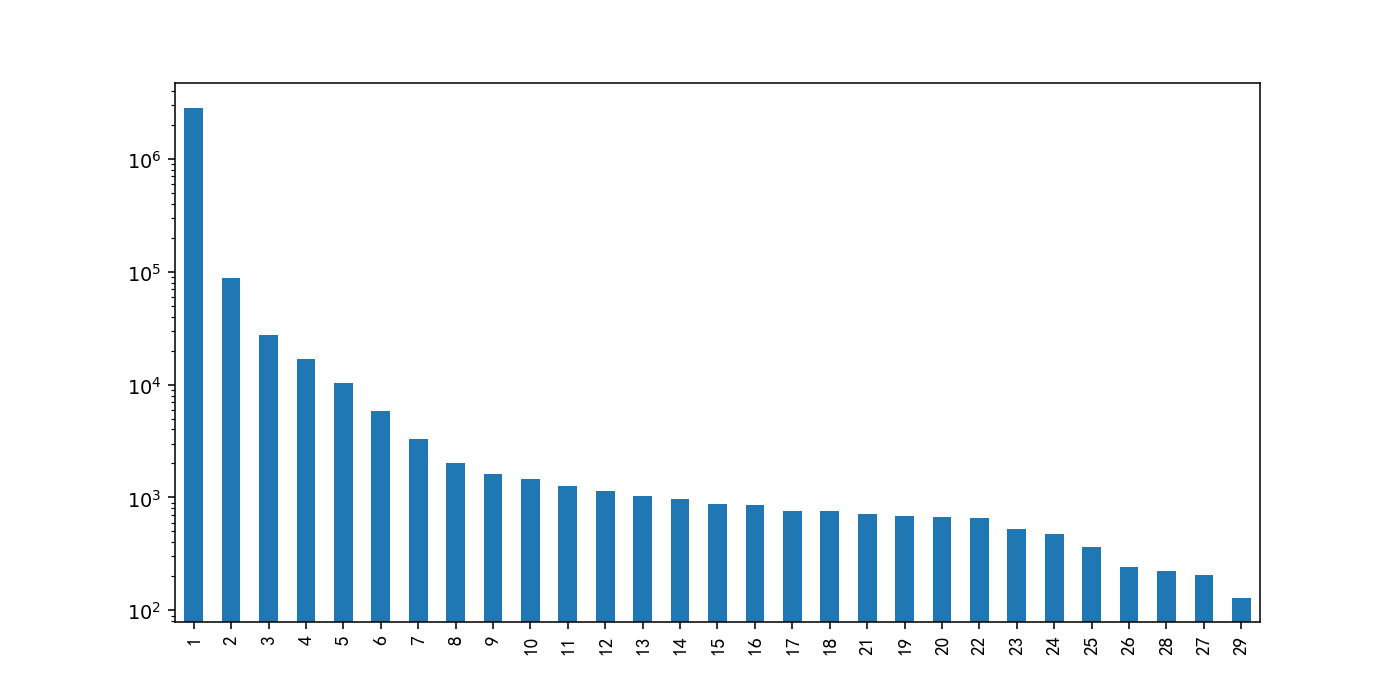

In [75]:
mac_day = data.groupby(['mac'])['date'].apply(lambda x:len(set(x)))
mac_day.value_counts().plot(kind='bar',logy=True)

In [28]:
#标注mac的类型：游客/员工/设备/随机
threshold=8  #从上图看，感觉取8天为界限比较合适
data['type']=np.where(data.mac.isin(mac_day[mac_day<threshold].index), 'visitor', 'worker')
data['type']=np.where(data.vendor=='Random Mac', 'Random Mac', data.type)
data['type']=np.where(data.vendor.isin(device), 'device', data.type)
data.to_csv(folder+'/data/tw_5min.csv',index=False,header=True)

随机mac的数据量占总数据量的一半，这点需要进一步观察

In [18]:
#将在黄山上出现过的mac的up属性标为True
data['up']=np.where(data.mac.isin(set(data[data.ap_seq.isin([1,2,3,14,15,18])==False].mac)),True,False)

In [ ]:
#change the order of columns for easy reading
data=data.set_index(['date','mac','tw','ap_seq','area_id','cnt']).reset_index()
#sort the order of records
data=data.sort_values(by=['date','mac','tw']).reset_index(drop=True)

data.to_csv(folder+'/data/tw_5min.csv',index=False,header=True)

# Loading data

In [43]:
#载入ap点位
ap = pd.read_csv(folder+'/map&info/AP.csv', encoding='gbk')
ap.location = ap.location.astype(str)
#不同区域的代码，同一区域可能有多个ap
area = pd.read_csv(folder+'/map&info/area.csv', encoding='gbk')
area.area = area.area.astype(str)
ap = pd.merge(ap, area).sort_values('ap_seq')
ap

ap_seq      ap       location  area location_C    x    y  area_id
0        0  C0AA40    YKS_dinning   YKS     迎客松_餐厅  165   87       11
2        1  C0AA42        YG_down  YG_D       云谷_下  208   48        9
3        2  C0AA4C  XGX_reception   XGX     新国线_前台   58    9        7
4        3  C0AA4E     XGX_ticket   XGX     新国线_售票   58    9        7
5        4  C0AA50          YG_up  YG_U       云谷_上  283   94       10
1        5  C0AA56  YKS_reception   YKS     迎客松_前台  165   87       11
6        6  C0AA5A          YP_up  YP_U       玉屏_上  140   97       13
7        7  C0AA64         XH_bar    XH      西海_吧台  212  173        8
9        8  C327DA            GMD   GMD        光明顶  169  133        1
8        9  C327DE   XH_reception    XH      西海_前台  212  173        8
10      10  C327E2             SL    SL         狮林  223  129        3
11      11  C327E8            PYL   PYL        排云楼  190  189        2
12      12  C327F0          TP_up  TP_U       太平_上  159  225        6
13      13  C327F4   BH_reception    BH      北海_前台  233  142        0
15      14  C3287A       YP_down0  YP_D      玉屏_下入  128   40       12
16      15  C55E0A       YP_down1  YP_D      玉屏_下票  128   40       12
17      16  C55E4A          TH_by    TH      天海_白云  154  139        4
18      17  C55E76        TH_bld3    TH     天海_3号楼  154  139        4
19      18  C64F74        TP_down  TP_D       太平_下  294  226        5
14      19  CF5C6E       BH_plaza    BH      北海_广场  233  142        0

In [72]:
tw_span=5.0
data=pd.read_csv(folder+'/data/tw_5min.csv')
data['date'] = pd.to_datetime(data.date)
print len(data)
data.head()

8662956


date           mac   tw  ap_seq  area_id  cnt                ssid  tw_all     type    up                 vendor
0 2017-01-19  000668042DD9  190      18        5    7         太平索道免费WiFi.     190  visitor  True  Vicon Industries Inc.
1 2017-01-19  000668042DD9  191      18        5   24         太平索道免费WiFi.     191  visitor  True  Vicon Industries Inc.
2 2017-01-19  000668042DD9  192      18        5   11         太平索道免费WiFi.     192  visitor  True  Vicon Industries Inc.
3 2017-01-19  000668042DD9  195      18        5    7                   .     195  visitor  True  Vicon Industries Inc.
4 2017-01-19  000668042DD9  196      18        5   23   TAIPIN_Free_WiFi.     196  visitor  True  Vicon Industries Inc.

# Preliminary analysis

日间变化

<IPython.core.display.Javascript object>


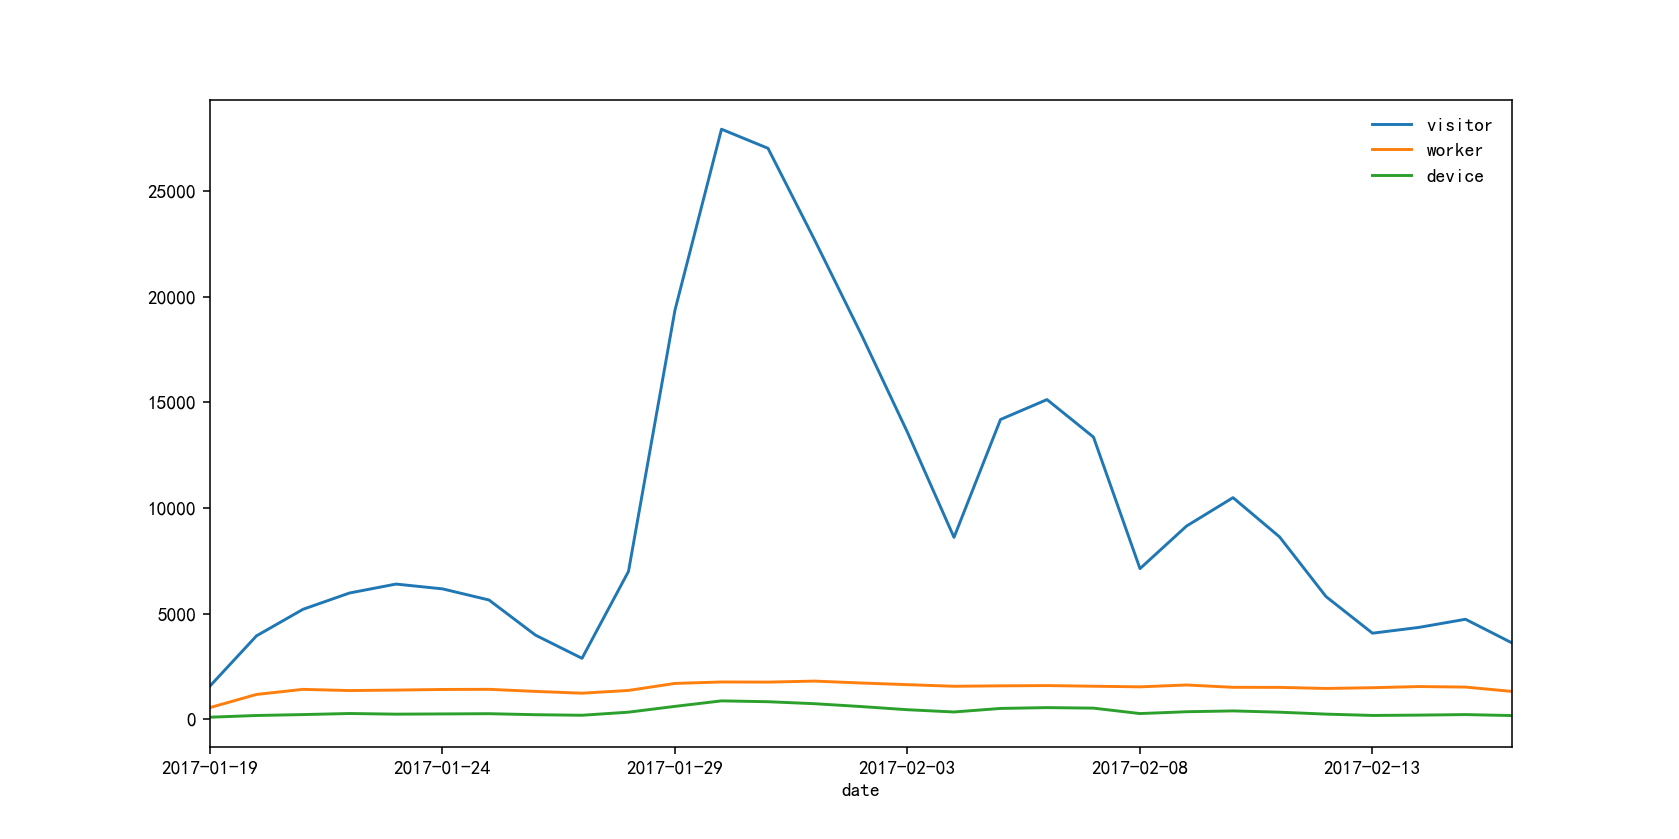

In [23]:
data[data.type=='visitor'].groupby('date')['mac'].apply(lambda x:len(set(x))).plot(label='visitor')
data[data.type=='worker'].groupby('date')['mac'].apply(lambda x:len(set(x))).plot(label='worker')
data[data.type=='device'].groupby('date')['mac'].apply(lambda x:len(set(x))).plot(label='device')
plt.legend()

<IPython.core.display.Javascript object>


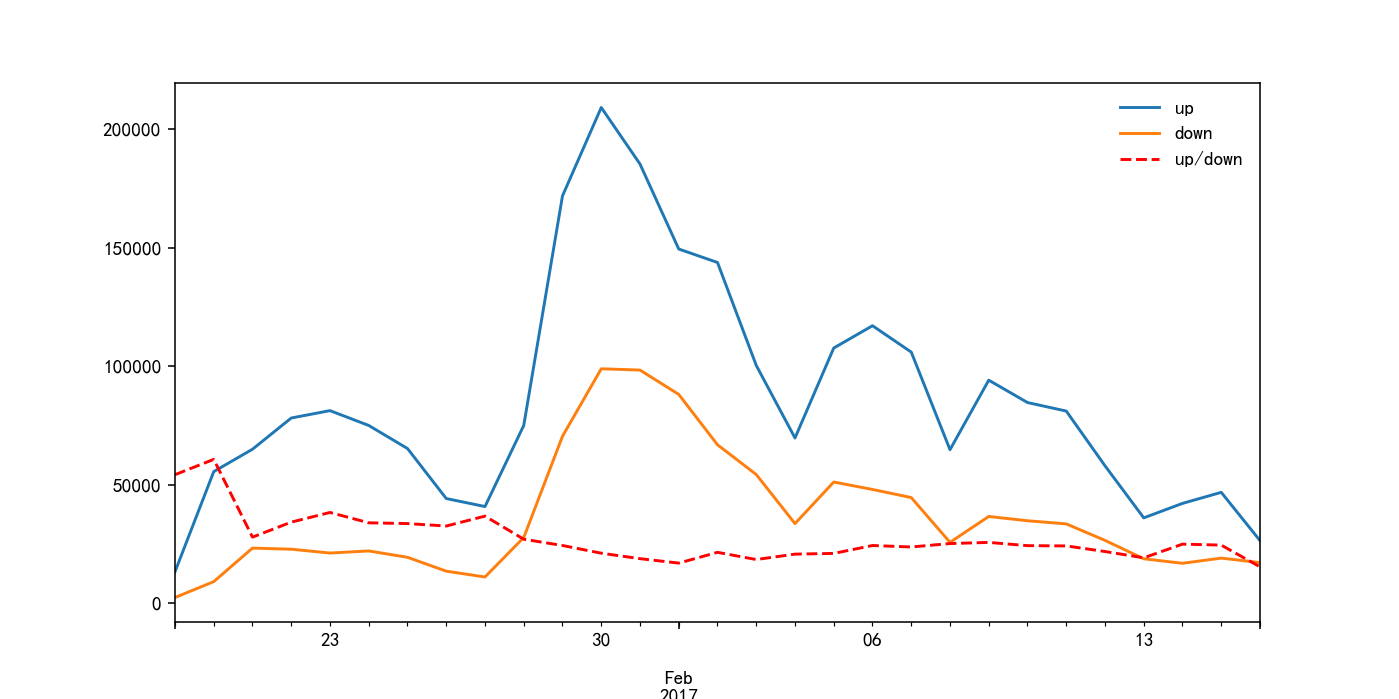

In [26]:
data[data.up].groupby('date')['mac'].apply(lambda x:len(set(x))).plot(label='up')
data[data.up==False].groupby('date')['mac'].apply(lambda x:len(set(x))).plot(label='down')
(10000*data[data.up].groupby('date')['mac'].apply(lambda x:float(len(set(x))))/data[-data.up].groupby('date')['mac'].apply(lambda x:len(set(x)))).plot(style='r--',label='up/down')
plt.legend()
#山上山下情况变化比较一致

<IPython.core.display.Javascript object>


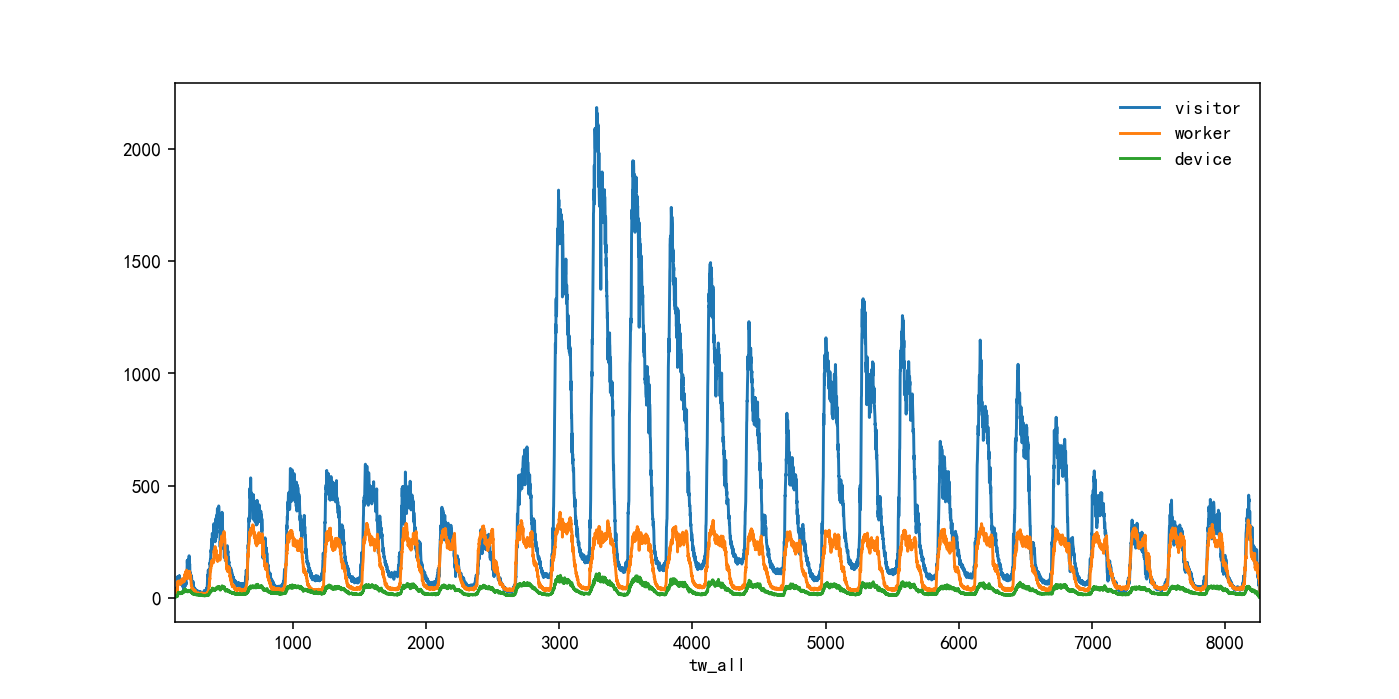

In [6]:
data[data.type=='visitor'].groupby('tw_all')['mac'].apply(lambda x:len(set(x))).plot(label='visitor')
data[data.type=='worker'].groupby('tw_all')['mac'].apply(lambda x:len(set(x))).plot(label='worker')
data[data.type=='device'].groupby('tw_all')['mac'].apply(lambda x:len(set(x))).plot(label='device')
plt.legend()

<IPython.core.display.Javascript object>


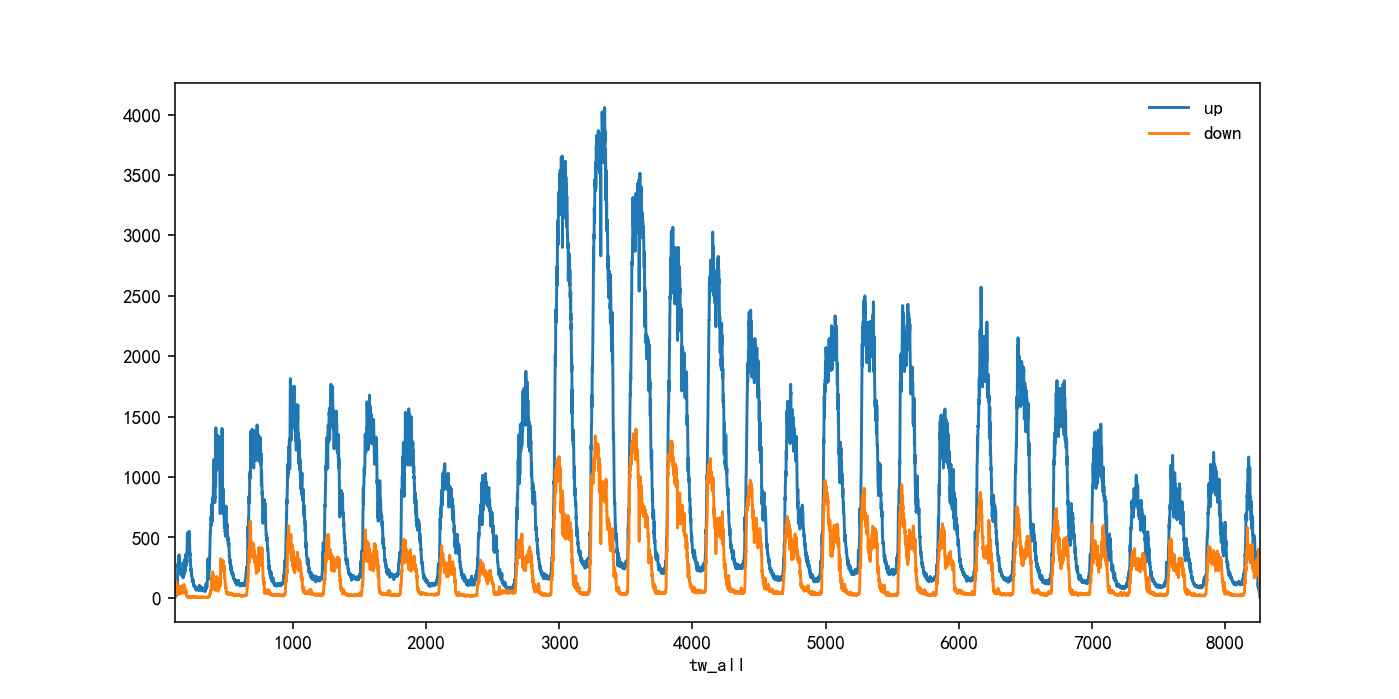

In [27]:
data[data.up].groupby('tw_all')['mac'].apply(lambda x:len(set(x))).plot(label='up')
data[-data.up].groupby('tw_all')['mac'].apply(lambda x:len(set(x))).plot(label='down')
plt.legend()

finding ap failure

<IPython.core.display.Javascript object>


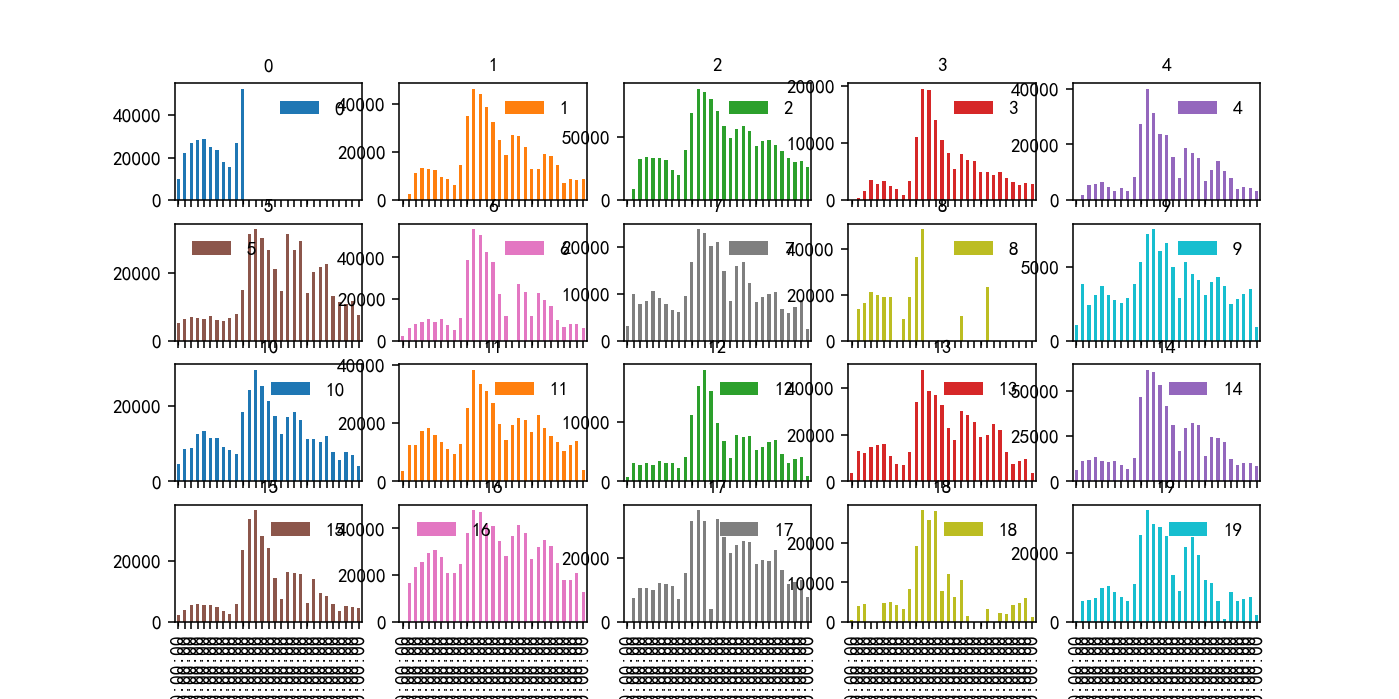

In [73]:
data.groupby(['ap_seq','date']).apply(len).reset_index(name='cnt').pivot('date','ap_seq','cnt').plot(kind='bar',subplots=True,layout=[4,5]);

1月29日之前的设备基本正常工作，每处的变化规律同总人数的变化规律基本一致

<IPython.core.display.Javascript object>


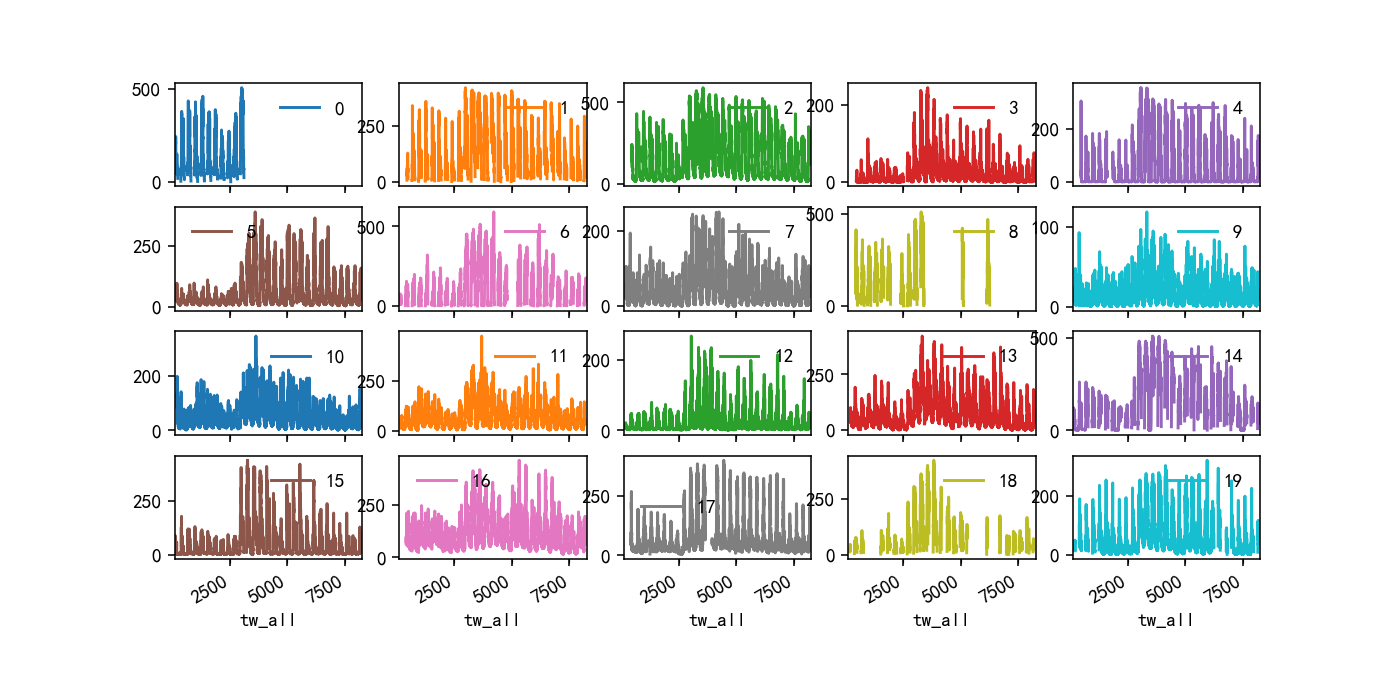

In [6]:
data.groupby(['ap_seq','tw_all']).apply(len).reset_index(name='cnt').pivot('tw_all','ap_seq','cnt').plot(subplots=True,layout=[4,5]);

In [51]:
# 发现将每天人数经由总人数标准化后的看得更清楚
x=data[data.up].groupby('date')['mac'].apply(lambda x:len(set(x)))
y=data[data.up].groupby('tw_all')['mac'].apply(lambda x:len(set(x)))

y=y.reset_index(name='num')
y['day']=(y.tw_all*tw_span/24/60).astype(int)
y['day_num']=x.ix[y.day].values
y['ratio']=y.num/y.day_num

<IPython.core.display.Javascript object>


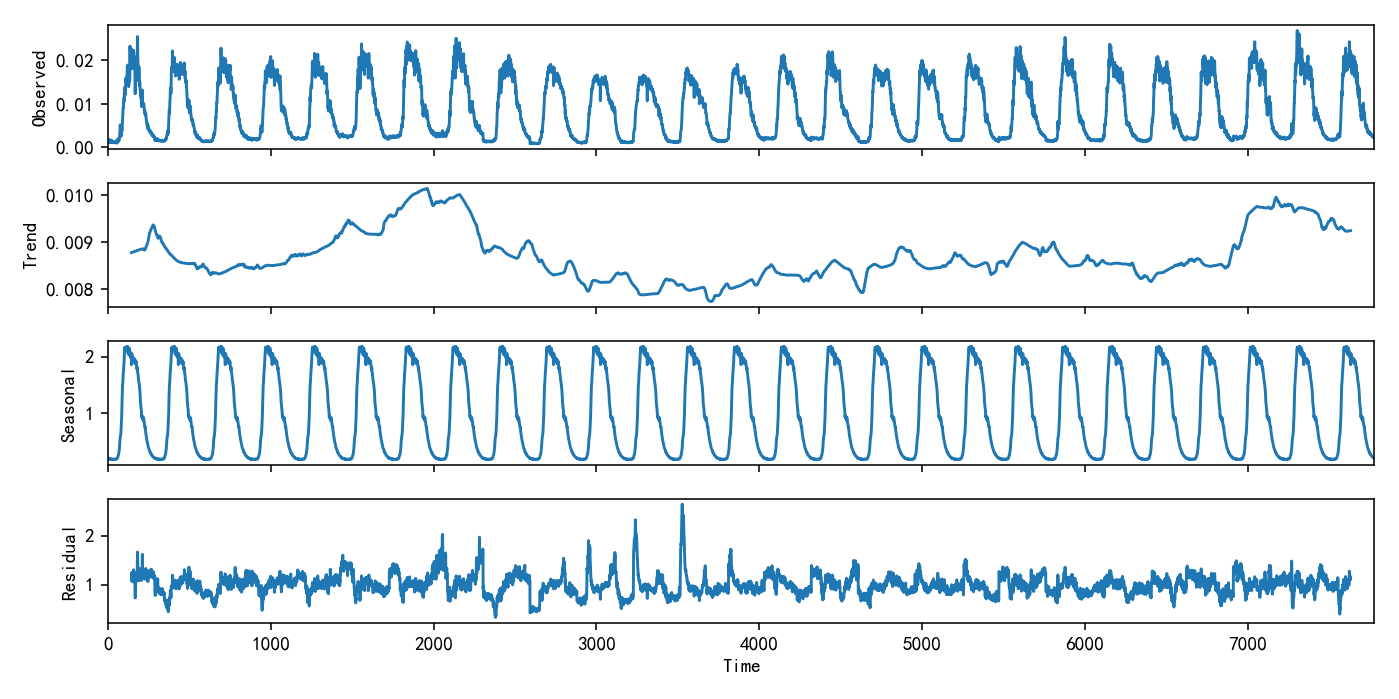

<IPython.core.display.Javascript object>


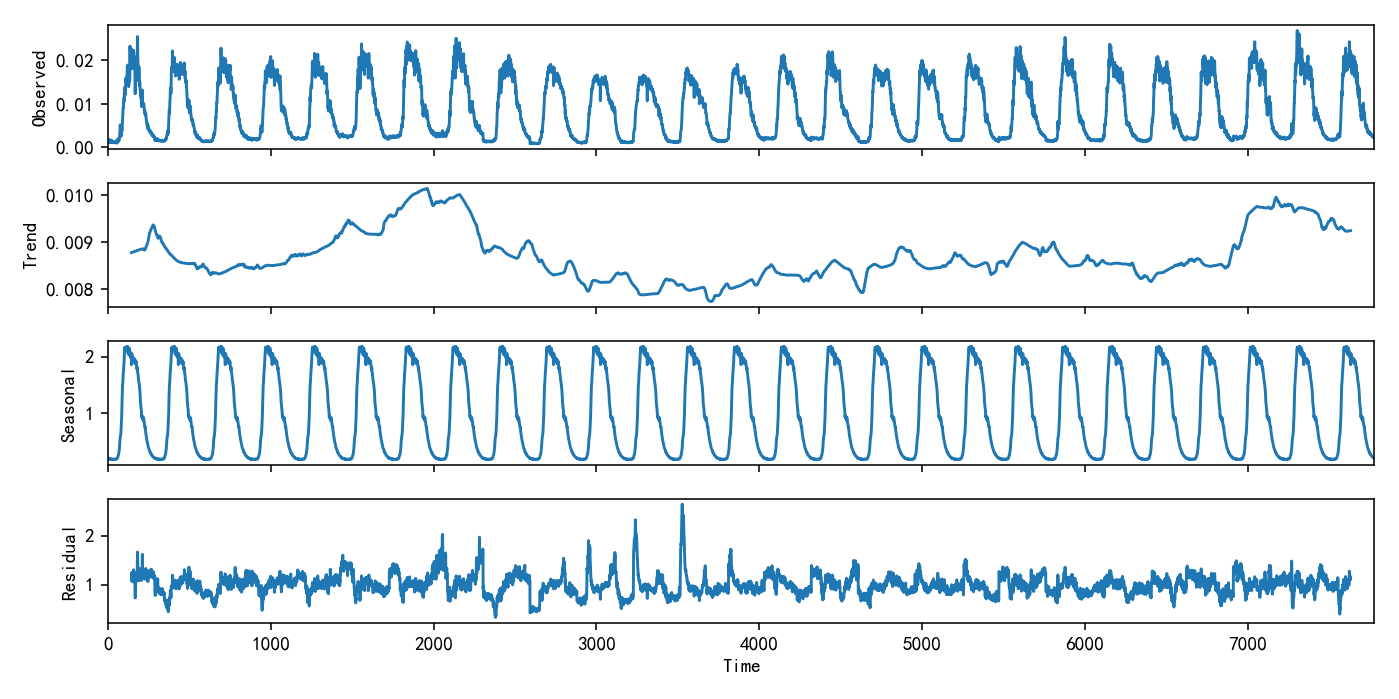

In [85]:
import statsmodels.api as sm
res=sm.tsa.seasonal_decompose(y[(y.day>0) & (y.day<28)].ratio.values,freq=int(24*60/tw_span),model='multiplicative')
res.plot()

日内

In [6]:
'''
def cal_attributes(group):
    r=dict()
    #group=group.sort_values(by='tw') #not nessicery as it has been done beforehand
    
    r['type']=group.type.iloc[0]
    r['up']=group.up.iloc[0]
    r['vendor']=group.vendor.iloc[0]
    r['num_records']=len(group)
    r['num_loc']=len(set(group.ap_seq))
    r['num_area']=len(set(group.area_id))
    r['tmin']=group.tw.iloc[0]
    r['tmax']=group.tw.iloc[-1]
    r['arr_ap']=group.ap_seq.iloc[0]
    r['dept_ap']=group.ap_seq.iloc[-1]
    return pd.Series(r)

attr=data[data.type!='Random Mac'].groupby(['mac','date']).apply(cal_attributes)'''


x=data.groupby(['mac','date'])
attr=pd.DataFrame({'type':x.type.first(),'up':x.up.first(),'vendor':x.vendor.first(),                
                'num_tw':x.size(),'num_loc':x.apply(lambda g:len(set(g.ap_seq))),
                'num_area':x.apply(lambda g:len(set(g.area_id))),
                'tmin':x.tw.min(),'tmax':x.tw.max(),
                'arr_ap':x.ap_seq.first(),'dept_ap':x.ap_seq.last()})

attr.to_csv(folder+'/data/attr.csv',index=True,header=True)

In [16]:
attr=pd.read_csv(folder+'/data/attr.csv')
attr['date'] = pd.to_datetime(attr.date)
print len(attr)
attr.head()

3544163


mac       date  arr_ap  dept_ap  num_area  num_loc  num_tw  tmax  tmin     type     up             vendor
0  00000000E254 2017-02-07      14       15         1        2       2    88    87  visitor  False  XEROX CORPORATION
1  0000000145B0 2017-02-02       2        2         1        1       2   115   114  visitor  False  XEROX CORPORATION
2  00000001BD0B 2017-02-01      14       14         1        1       9   172   151  visitor  False  XEROX CORPORATION
3  000000087A4D 2017-01-24       1       15         2        2       3   189   112  visitor  False  XEROX CORPORATION
4  0000005F09D1 2017-01-30      14       14         1        1       1   207   207  visitor  False  XEROX CORPORATION

<IPython.core.display.Javascript object>


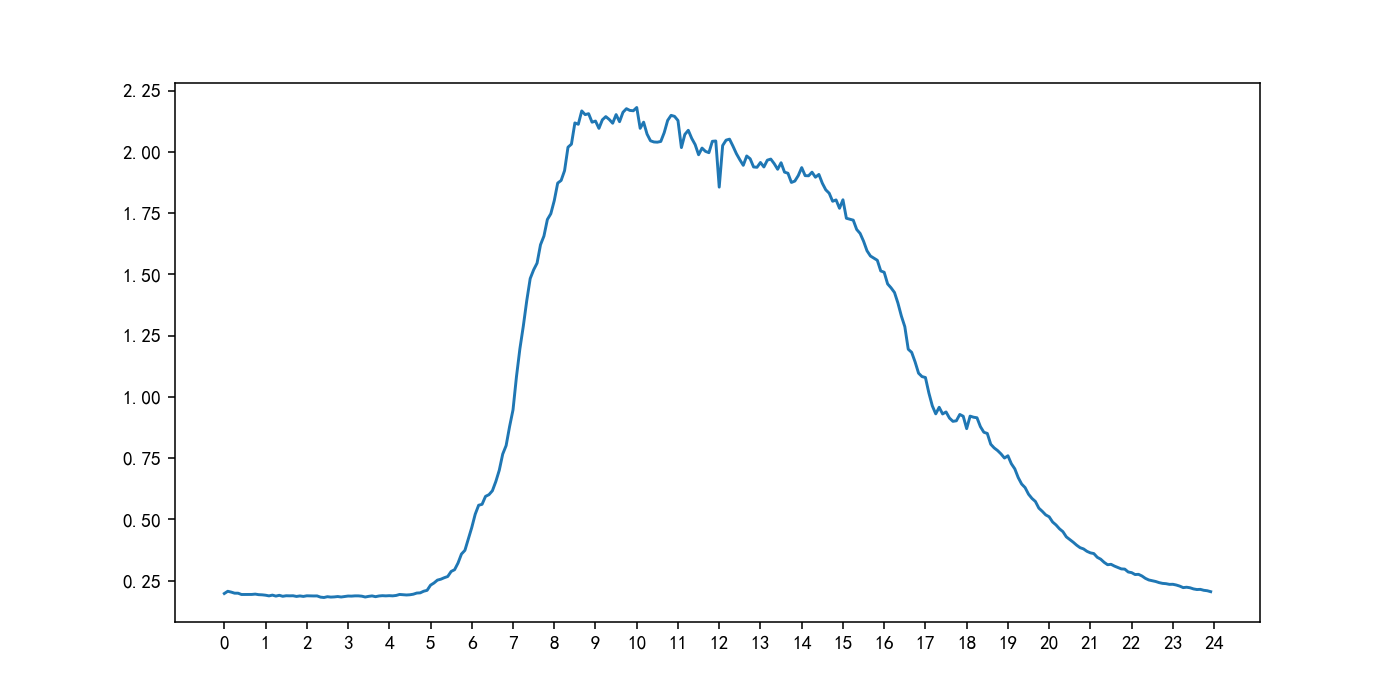

In [97]:
plt.plot(res.seasonal[:288])
t=np.arange(25)
plt.xticks(t*12,t);

<IPython.core.display.Javascript object>


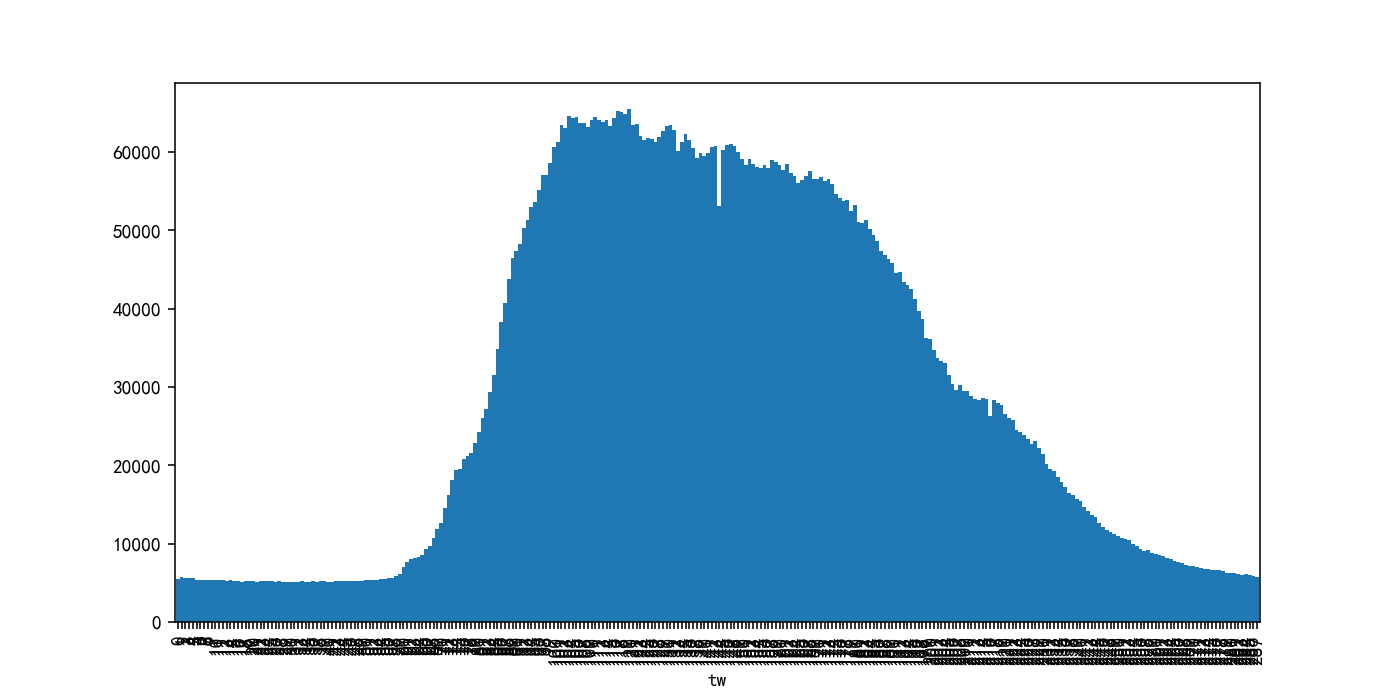

In [62]:
data.groupby('tw')['mac'].apply(lambda x:len(x)).plot(kind='bar',width=1)

<IPython.core.display.Javascript object>


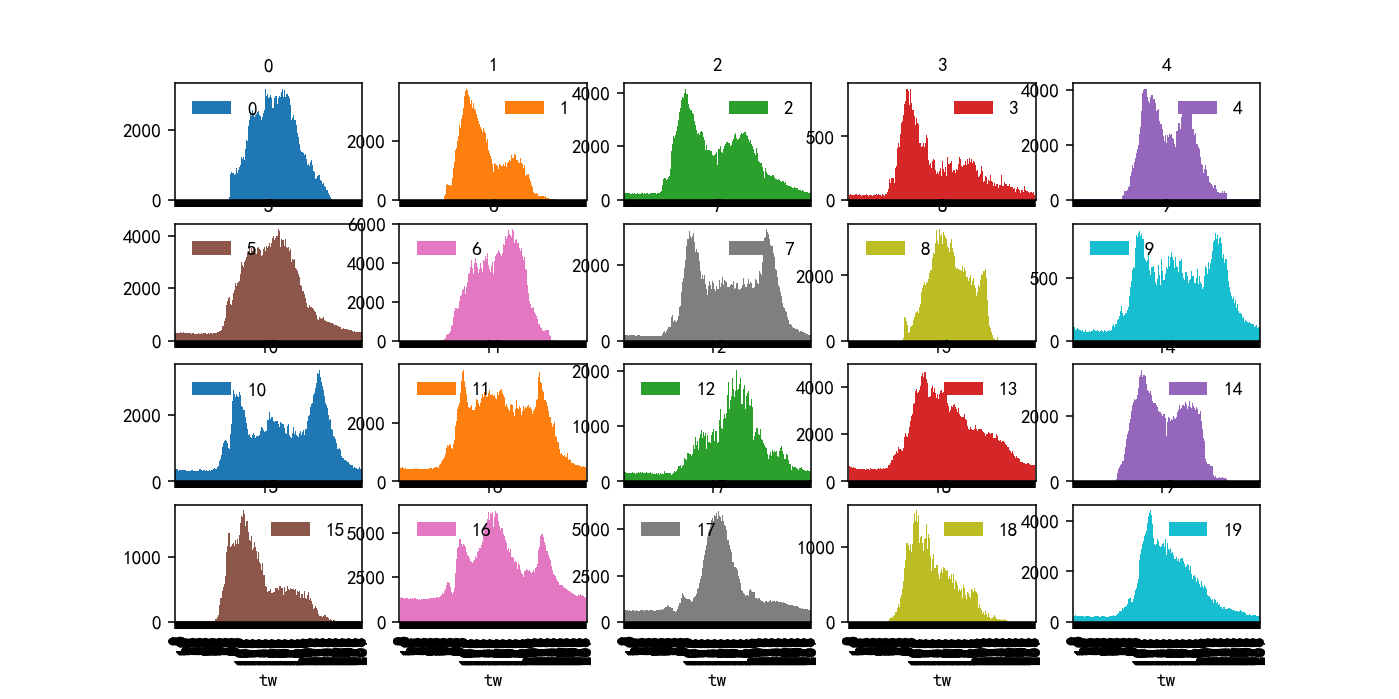

In [11]:
data[data.up].groupby(['ap_seq','tw']).apply(len).reset_index(name='cnt').pivot('tw','ap_seq','cnt').plot(kind='bar',width=1,subplots=True,layout=[4,5]);

<IPython.core.display.Javascript object>


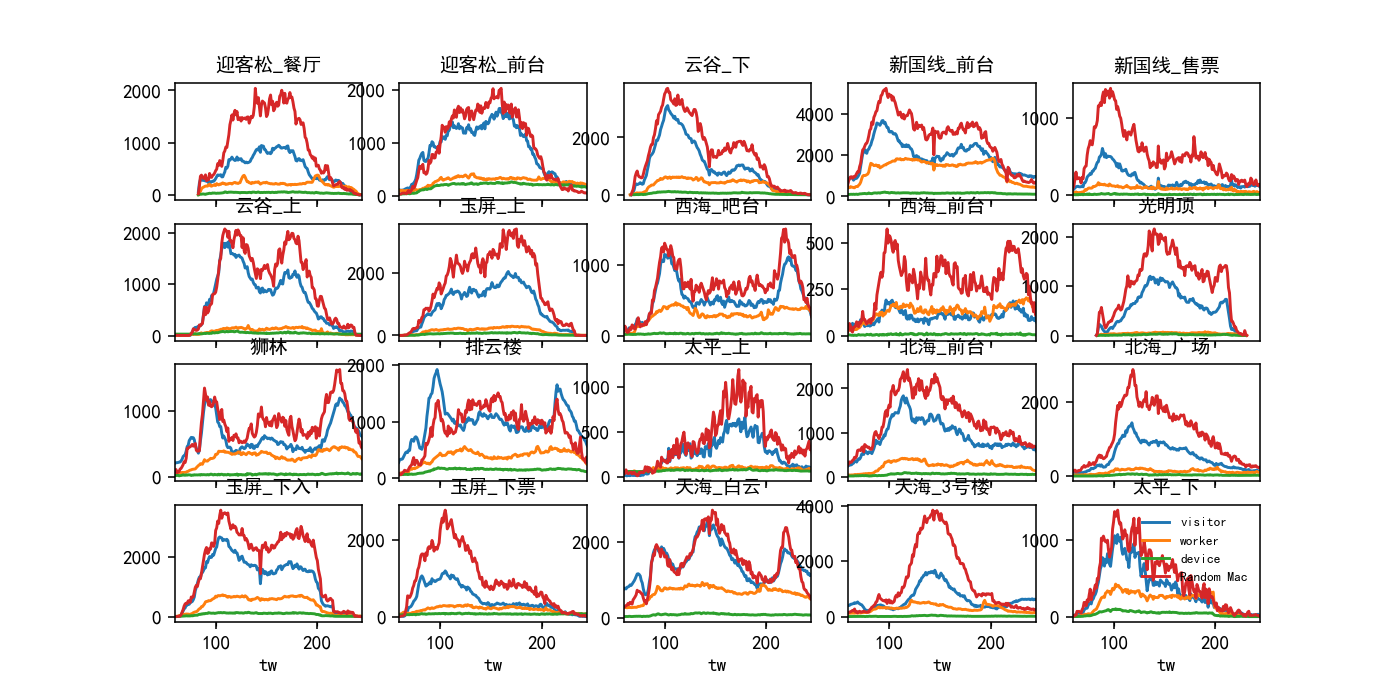

In [74]:
row,col=4,5
fig, axes = plt.subplots(row, col,sharex=True)
mac_types = ['visitor','worker','device','Random Mac']
for i in range(len(ap)):
    temp=data[data.ap_seq==ap.ap_seq[i]]
    for j in mac_types:
        temp[temp.type==j].groupby('tw').apply(len).plot(label=j,ax=axes[i/col][i%col])
    axes[i/col][i%col].set_title(ap.location_C[i])
plt.legend(fontsize='x-small',loc='best')  

<IPython.core.display.Javascript object>


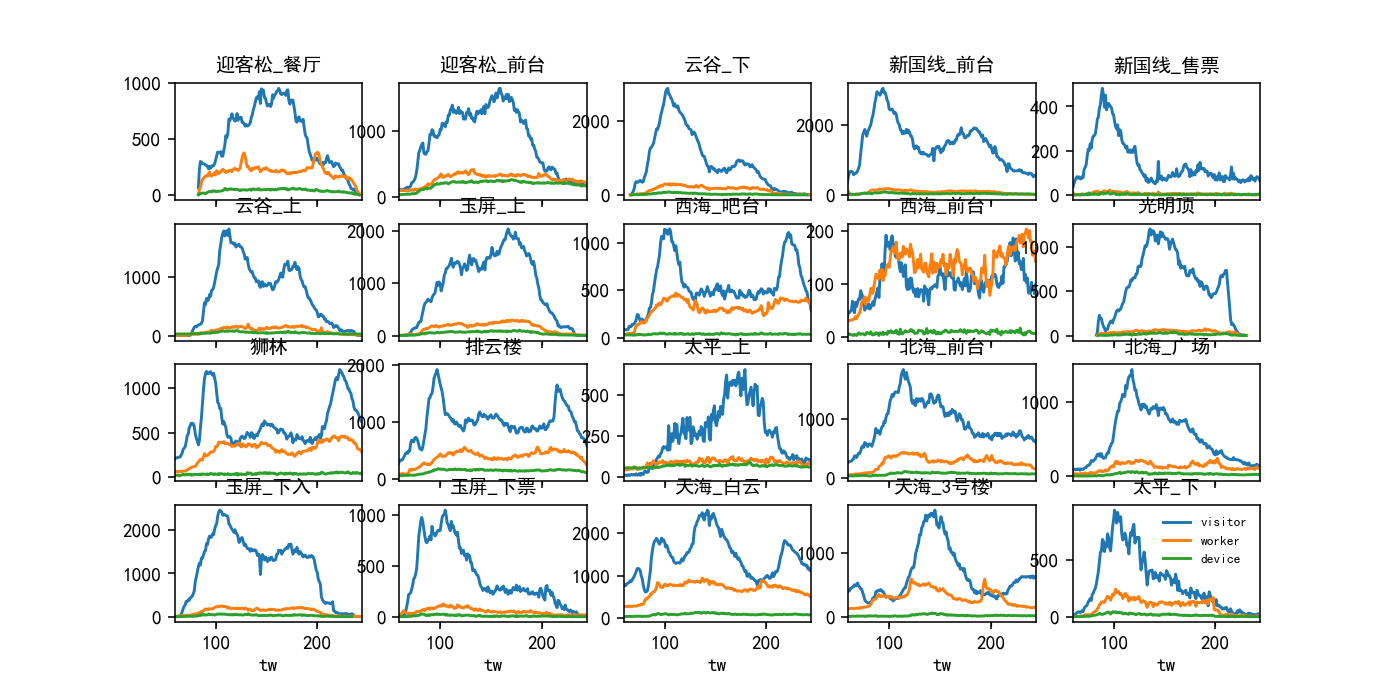

In [26]:
row,col=4,5
fig, axes = plt.subplots(row, col,sharex=True,sharey=False)
mac_types = ['visitor','worker','device']
for i in range(len(ap)):
    temp=data[data.ap_seq==ap.ap_seq[i]]
    temp=temp[temp.up]
    for j in mac_types:
        temp[temp.type==j].groupby('tw').apply(len).plot(label=j,ax=axes[i/col][i%col])
    axes[i/col][i%col].set_title(ap.location_C[i])
plt.legend(fontsize='x-small',loc='best')  

同一地区基本趋势一致，光明顶跟迎客松餐厅晚上很可能断电

<IPython.core.display.Javascript object>


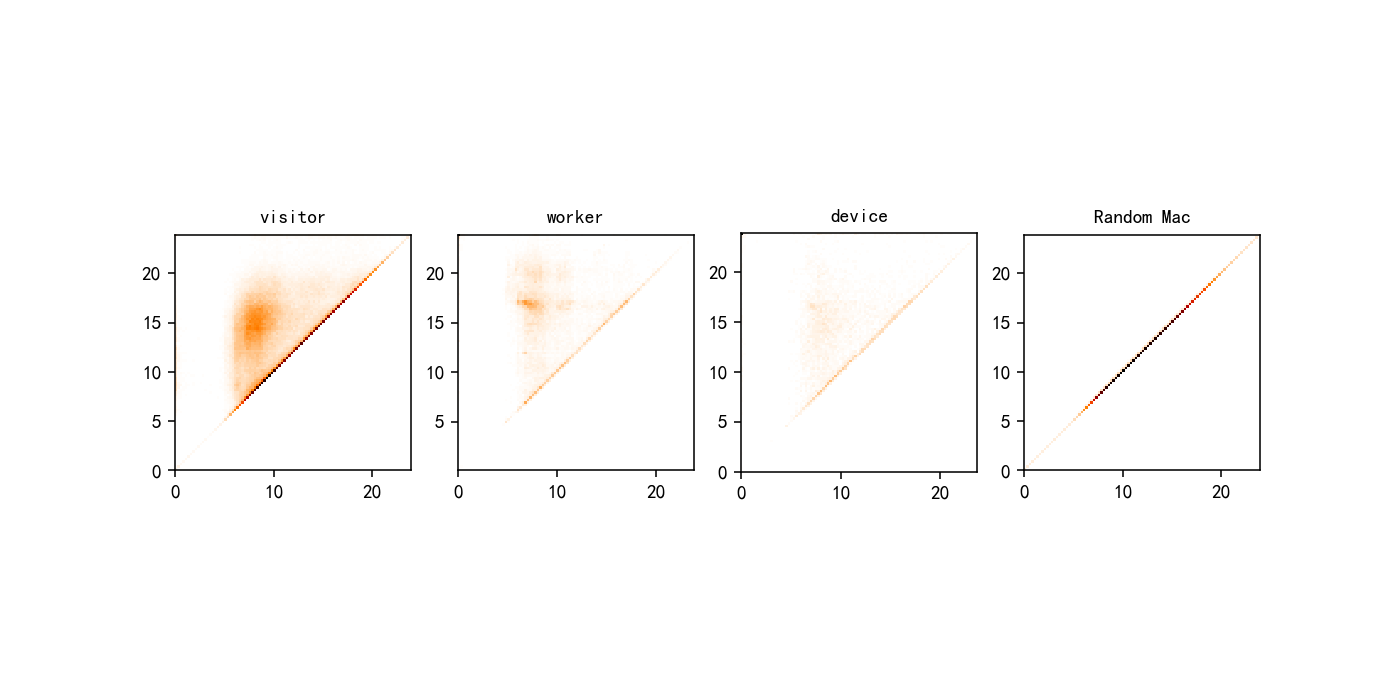

In [25]:
#到达离开时间
mac_types = ['visitor','worker','device','Random Mac']
fig, axes = plt.subplots(1, 4)
for i in range(4):
    temp = attr[attr.type==mac_types[i]]
    axes[i].hist2d(temp.tmin/12.0, temp.tmax/12.0, bins=96, cmap = 'gist_heat_r')
    axes[i].set_aspect('equal')
    axes[i].set_title(mac_types[i]);

<IPython.core.display.Javascript object>


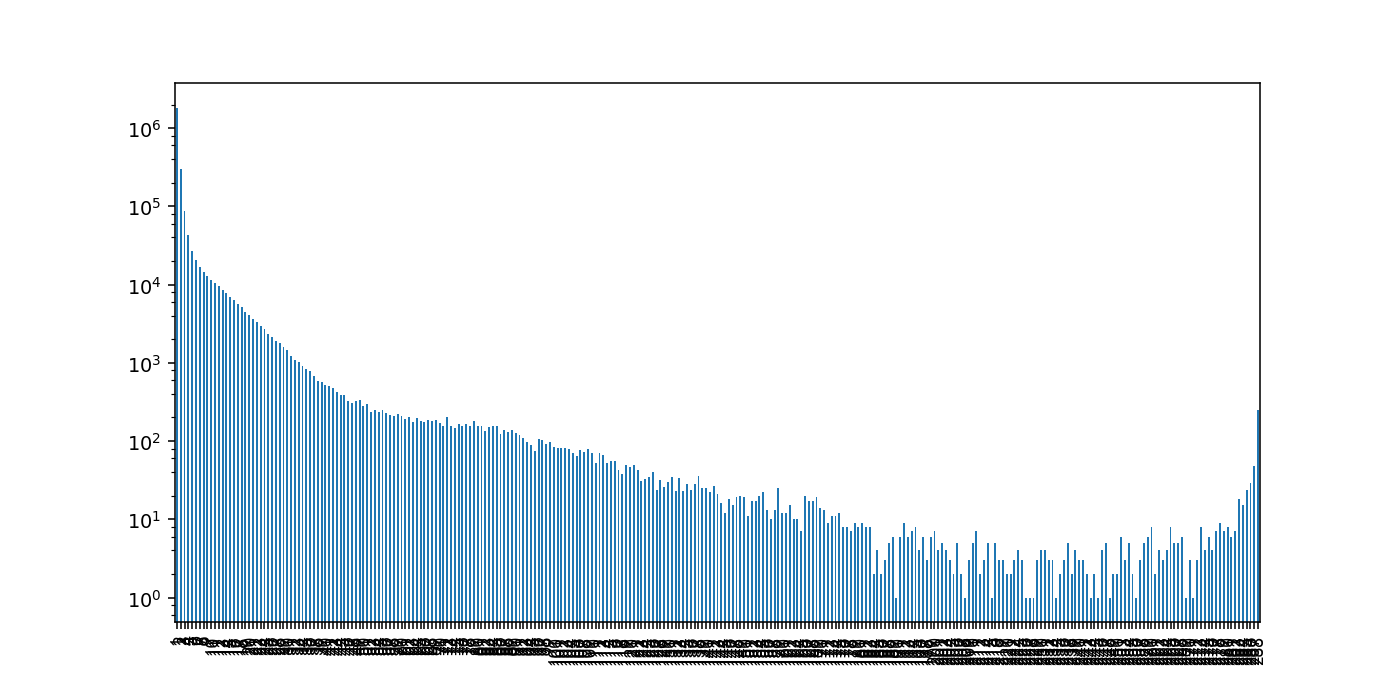

In [34]:
attr[attr.up].num_tw.value_counts().sort_index().plot(kind='bar',logy=True)

<IPython.core.display.Javascript object>


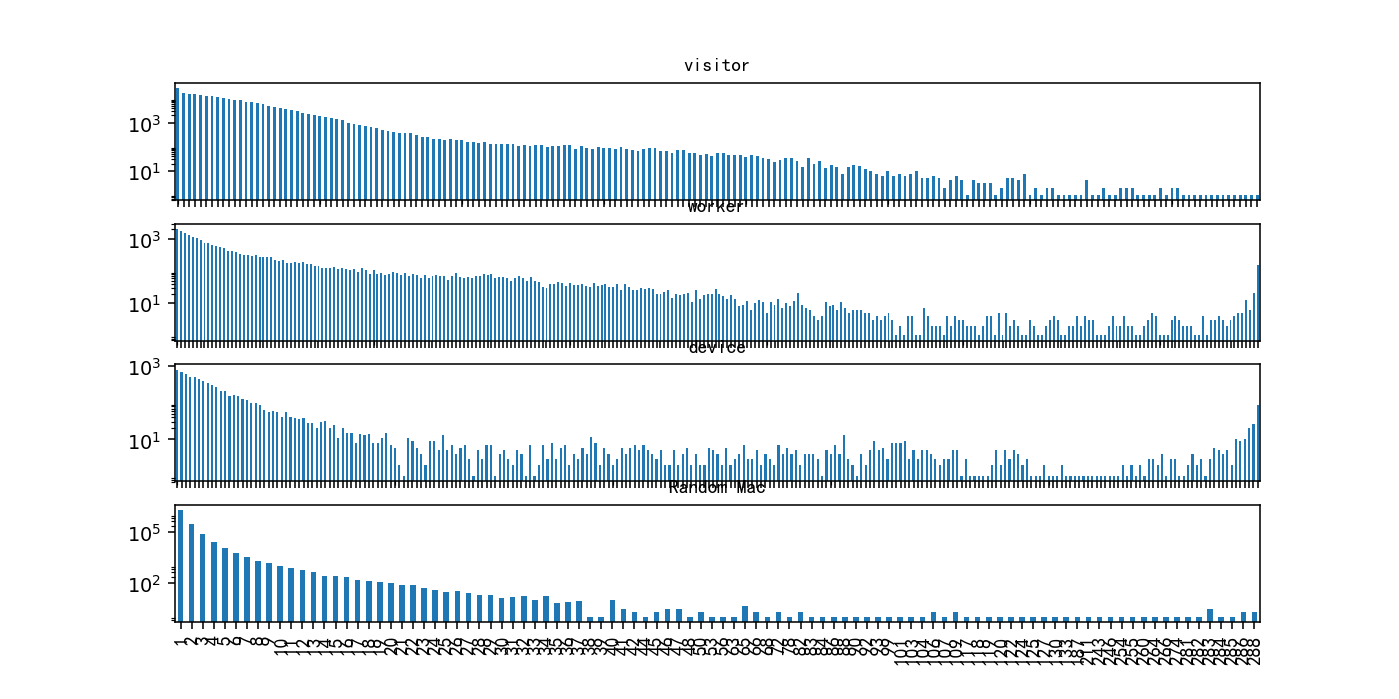

In [37]:
mac_types = ['visitor','worker','device','Random Mac']
fig, axes = plt.subplots(4, 1)
for i in range(4):
    temp = attr[attr.type==mac_types[i]]
    temp[temp.up].num_tw.value_counts().sort_index().plot(kind='bar',logy=True,ax=axes[i],sharex=True)
    axes[i].set_title(mac_types[i]);

<IPython.core.display.Javascript object>


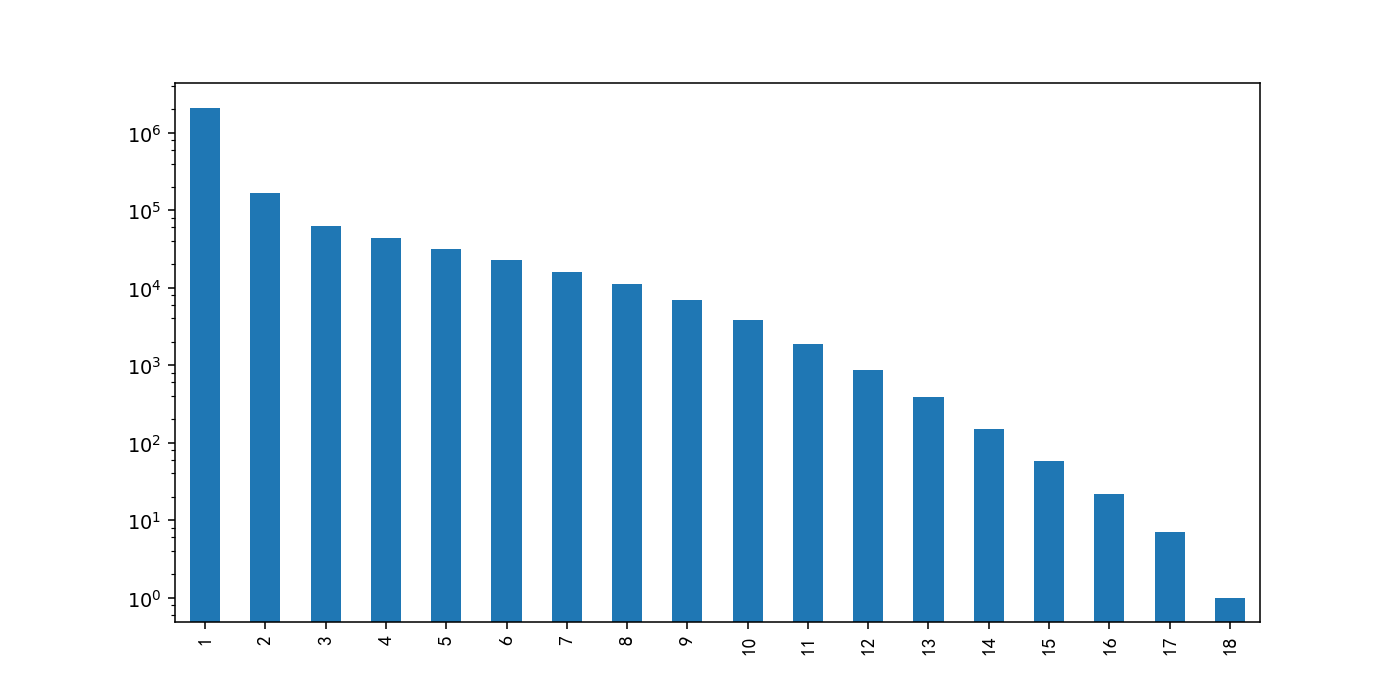

In [42]:
attr[attr.up].num_loc.value_counts().sort_index().plot(kind='bar',logy=True);

<IPython.core.display.Javascript object>


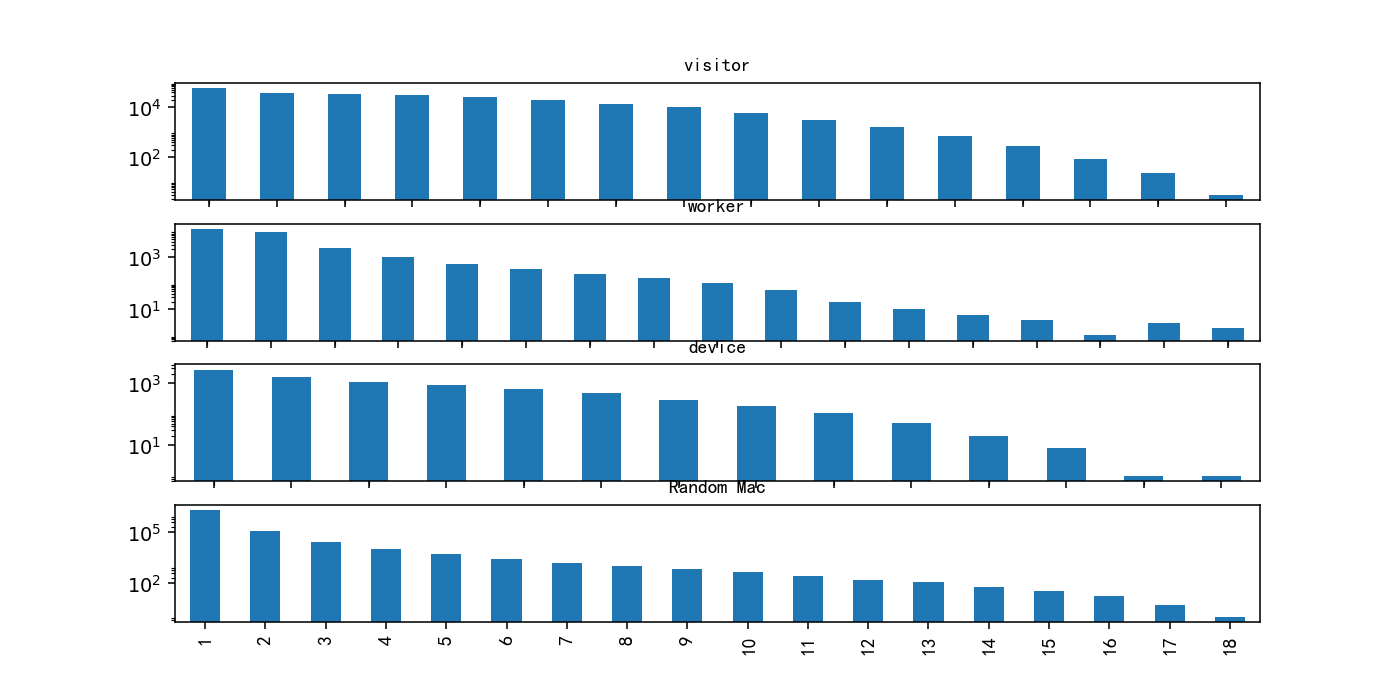

In [38]:
mac_types = ['visitor','worker','device','Random Mac']
fig, axes = plt.subplots(4, 1)
for i in range(4):
    temp = attr[attr.type==mac_types[i]]
    temp[temp.up].num_loc.value_counts().sort_index().plot(kind='bar',logy=True,ax=axes[i],sharex=True)
    axes[i].set_title(mac_types[i]);

<IPython.core.display.Javascript object>


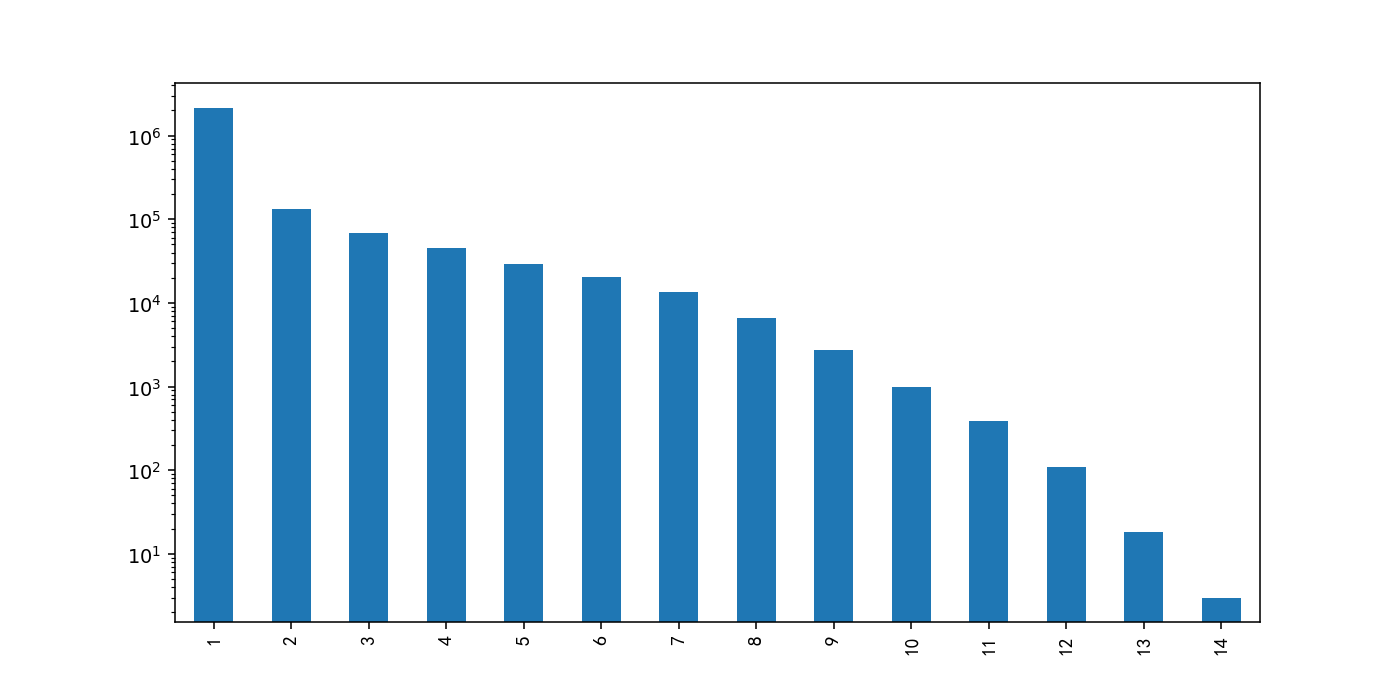

In [44]:
attr[attr.up].num_area.value_counts().sort_index().plot(kind='bar',logy=True);

<IPython.core.display.Javascript object>


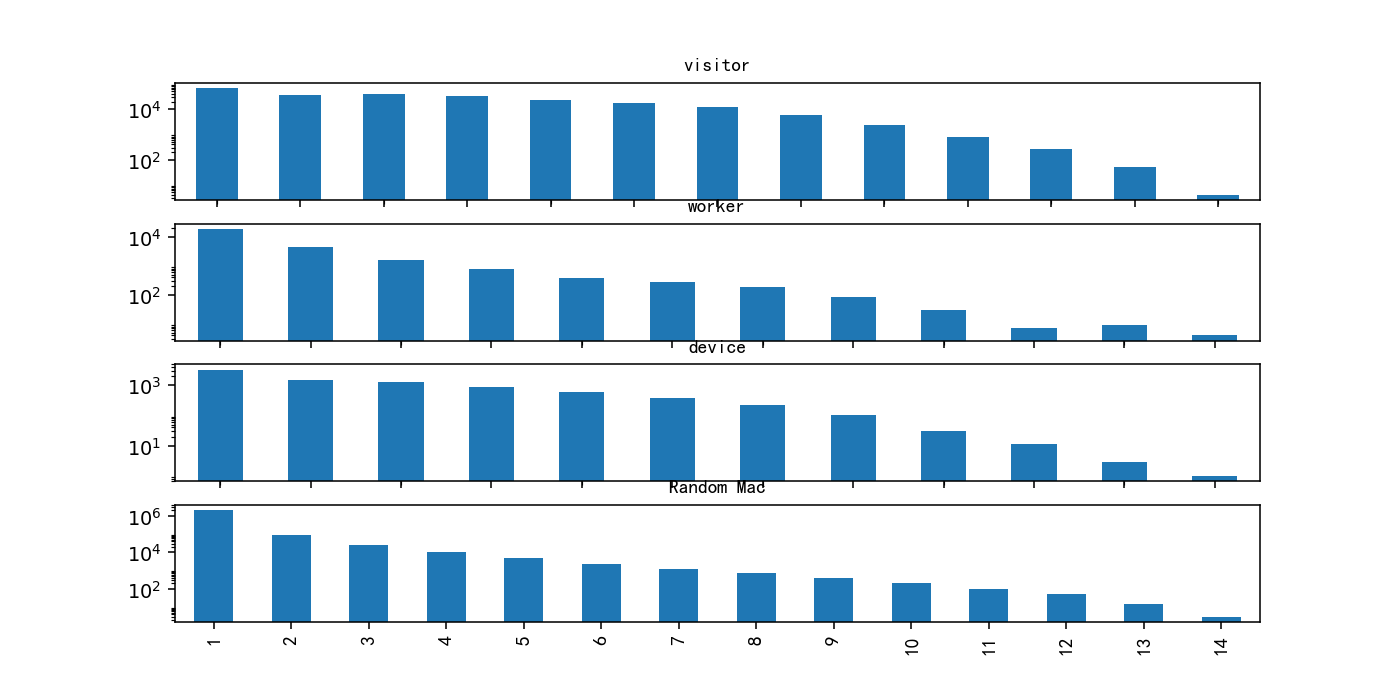

In [43]:
mac_types = ['visitor','worker','device','Random Mac']
fig, axes = plt.subplots(4, 1)
for i in range(4):
    temp = attr[attr.type==mac_types[i]]
    temp[temp.up].num_area.value_counts().sort_index().plot(kind='bar',logy=True,ax=axes[i],sharex=True)
    axes[i].set_title(mac_types[i]);

<IPython.core.display.Javascript object>


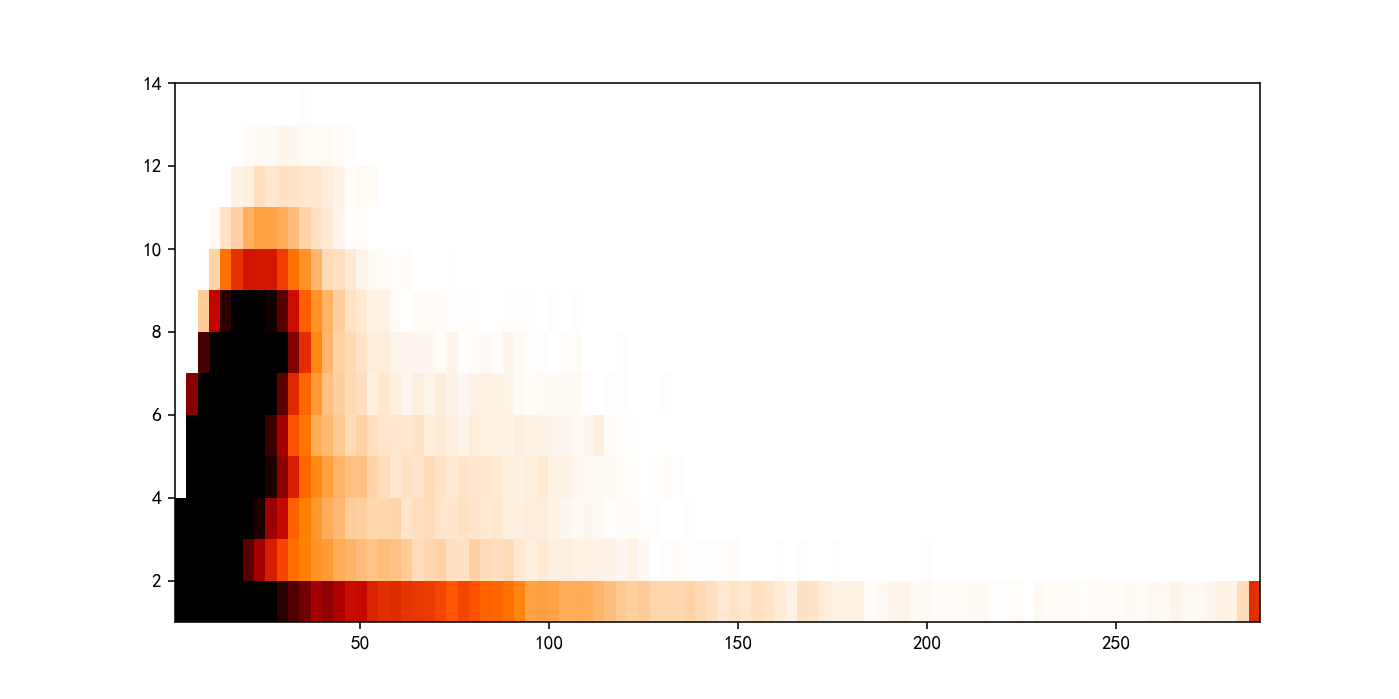

In [56]:
plt.hist2d(attr[attr.up].num_tw,attr[attr.up].num_area,bins=[96,13],cmap = 'gist_heat_r',vmax=800);

<IPython.core.display.Javascript object>


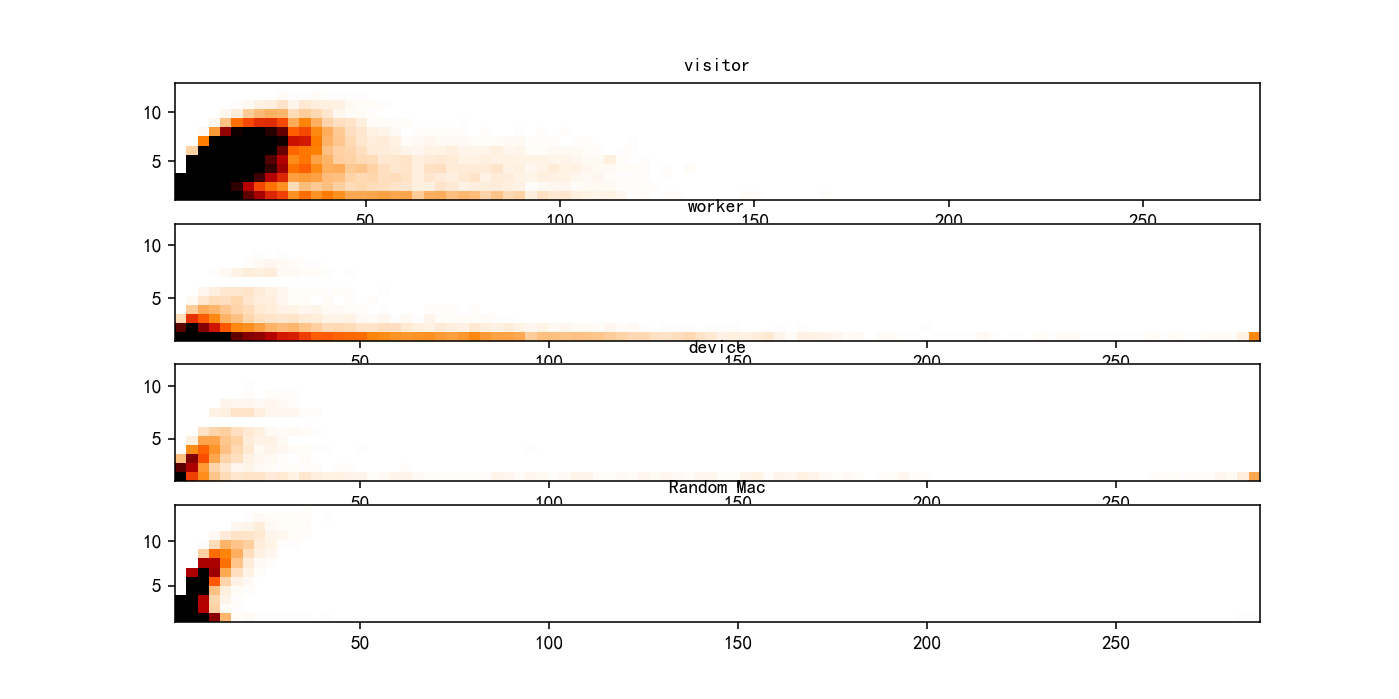

In [61]:
mac_types = ['visitor','worker','device','Random Mac']
fig, axes = plt.subplots(4, 1)
for i in range(4):
    temp = attr[attr.type==mac_types[i]]
    temp=temp[temp.up]
    axes[i].hist2d(temp.num_tw,temp.num_area,bins=[96,13],cmap = 'gist_heat_r',vmax=800);
    axes[i].set_title(mac_types[i]);

<IPython.core.display.Javascript object>


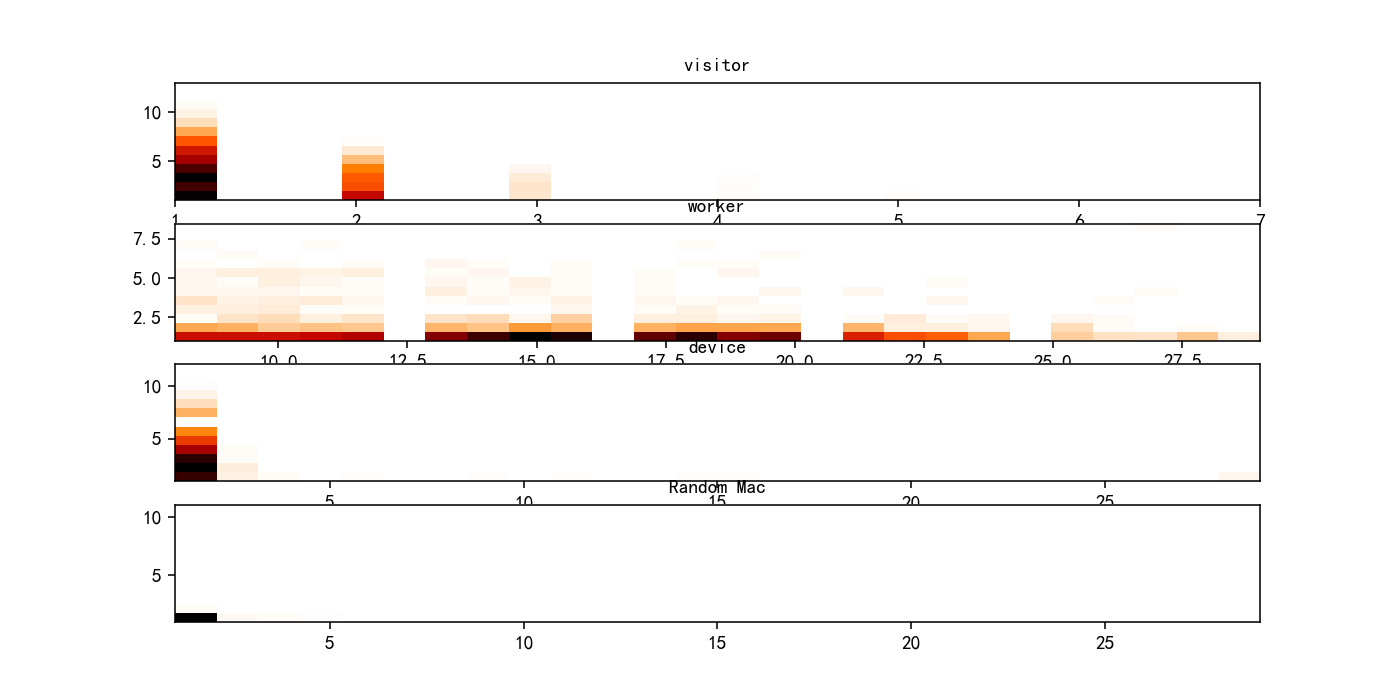

In [37]:
mac_types = ['visitor','worker','device','Random Mac']
fig, axes = plt.subplots(4, 1)
for i in range(4):
    temp = attr[attr.type==mac_types[i]]
    temp=temp[temp.up]
    
    axes[i].hist2d(temp.groupby('mac').apply(len),temp.groupby('mac').num_area.mean(),bins=[26,13],cmap = 'gist_heat_r');
    axes[i].set_title(mac_types[i]);

<IPython.core.display.Javascript object>


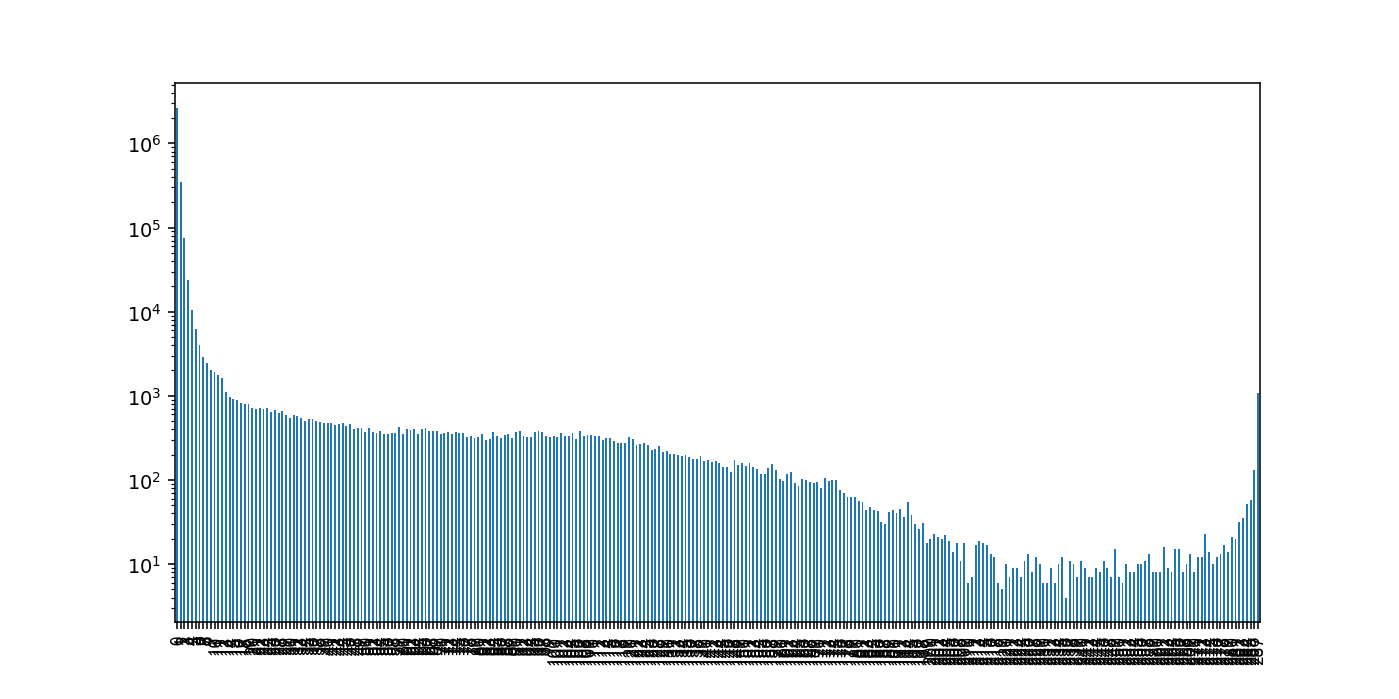

In [34]:
(attr[attr.num_area==1].tmax-attr[attr.num_area==1].tmin).value_counts().sort_index().plot(kind='bar',logy=True);

# Trace analysis

## Purging data

In [16]:
#purging data
attr_pd=attr[attr.up]
attr_pd=attr_pd[attr_pd.type!='worker']
attr_pd=attr_pd[attr_pd.num_tw>1]
attr_pd=attr_pd[-((attr_pd.type=='device')&(attr_pd.num_area==1)&(attr_pd.num_tw>30))]
len(attr_pd)

627299

In [18]:
data_pd=data.merge(attr_pd,on=['mac','date'],how='right')
len(data_pd)

## Data transformation

In [19]:
#generate trace
'''trace=data_pd.set_index('mac','day','tw')['ap_seq'].unstack() #数据太多，此法不行
x=data_pd.pivot(['mac','day'],'tw','ap_seq')                  #数据太多，此法不行'''
trace=data_pd.groupby(by=['mac','date']).apply(lambda group: group.set_index('tw')['area_id']).unstack() #替代方法

trace.to_csv(folder+'/data/tw_5min_trace.csv',index=True, header=True)

In [23]:
#compress trace into run length pattern
import itertools as itt
def run_length_coding(seq):
    if isinstance(seq,pd.Series) or isinstance(seq,pd.DataFrame):        
        seq=seq.values
    if isinstance(seq,np.ndarray):
        seq=seq.flatten()
#     aps=[k for k,g in itt.groupby(seq)]
#     lens=[len(list(g)) for k,g in itt.groupby(seq)]
    aps=[]
    lens=[]
    for k,g in itt.groupby(seq):
        aps += [k]
        lens += [len(list(g))]
    return pd.DataFrame({'ap_seq':aps,'stay':lens})

def run_length_coding2(seq):    
    return pd.Series([(k,len(list(g))) for k,g in itt.groupby(seq)])

In [24]:
trace=trace.fillna(999)
x=trace.apply(run_length_coding2,axis=1)  #DataFrame.apply(f) only support 1-d return in f
x=x.stack()  #for some unknown reasons the above 2 lines have to be seperated
y=zip(*x.values) #key point!
trace_coded=pd.DataFrame({'ap_seq':y[0],'stay':y[1]},index=x.index) #Manually create 2 columns from 1 series
trace_coded=trace_coded.reset_index()
trace_coded.columns=['mac','date','ith','ap_seq','stay']

trace_coded.to_csv(folder+'/data/trace_coded.csv',index=False, header=True)

In [10]:
def de_time(group):
    in_tw=0
    if group.ap_seq.iloc[0]==999 and group.ap_seq.iloc[-1]==999:
        in_tw=group.stay.iloc[0]
        group=group.iloc[1:-1]        
    elif group.ap_seq.iloc[0]==999:
        in_tw=group.stay.iloc[0]
        group=group.iloc[1:]        
    elif group.ap_seq.iloc[-1]==999:
        group=group.iloc[:-1]
    else:
        group=group
    group['in_tw']=in_tw
    return group

trace_detime=trace_coded.groupby(['mac','date']).apply(de_time).reset_index(drop=True)

trace_detime['ap_seq_prev']=trace_detime.groupby(['mac','date'])['ap_seq'].apply(lambda x: x.shift(1))
trace_detime['ap_seq_next']=trace_detime.groupby(['mac','date'])['ap_seq'].apply(lambda x: x.shift(-1))

trace_detime=trace_detime.sort_values(by=['date','mac','ith'])
trace_detime.columns=['mac','date','ith','area_id','stay','in_tw','area_id_prev','area_id_next']

trace_detime.to_csv(folder+'/data/trace_detime.csv',index=False,header=True)

## Trace preprocession

In [46]:
trace_detime=pd.read_csv(folder+'/data/trace_detime.csv')
print len(trace_detime)
trace_detime.head()

3278256


mac        date  ith  area_id  stay  in_tw  area_id_prev  area_id_next
0  000668042DD9  2017-01-19    1      5.0     3    190           NaN         999.0
1  000668042DD9  2017-01-19    2    999.0     2    190           5.0           5.0
2  000668042DD9  2017-01-19    3      5.0     3    190         999.0           NaN
3  0008221D5A07  2017-01-19    1      5.0     1    179           NaN         999.0
4  0008221D5A07  2017-01-19    2    999.0    10    179           5.0           2.0

#### 1. 停留缺失填补

<IPython.core.display.Javascript object>


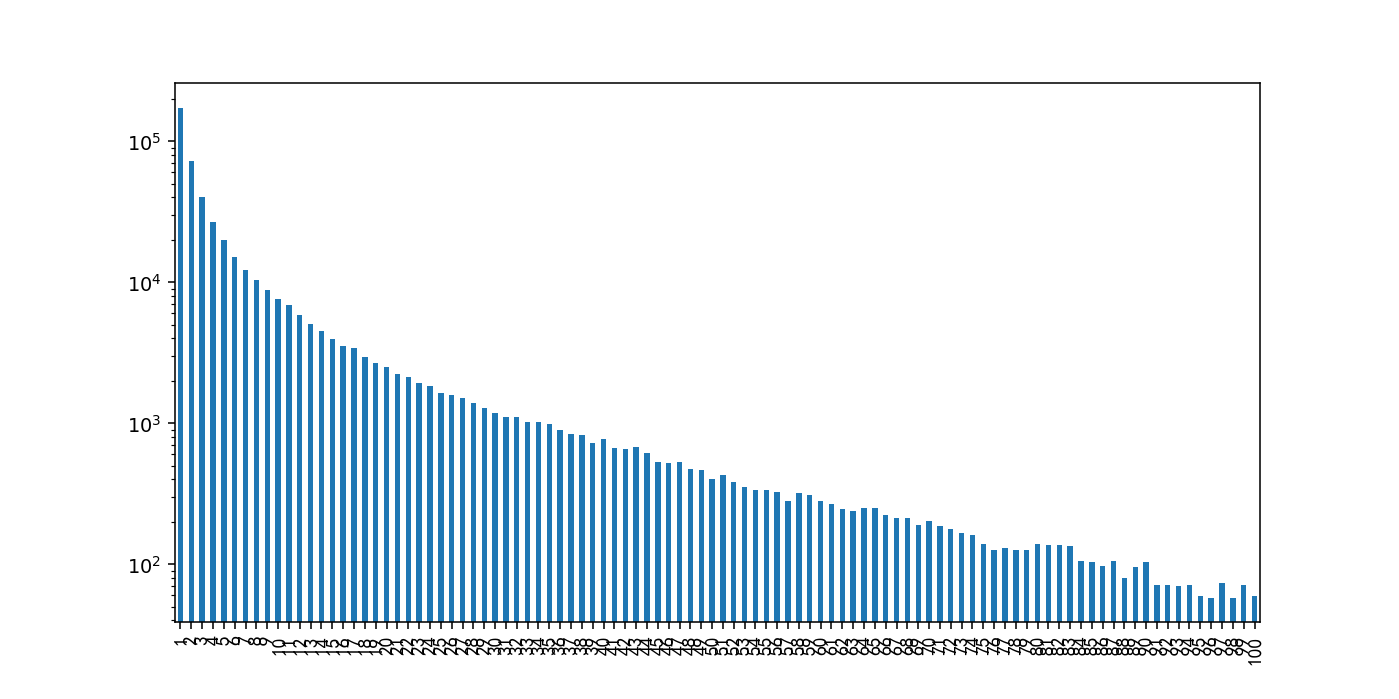

In [47]:
x=trace_detime[(trace_detime.area_id_prev==trace_detime.area_id_next) &(trace_detime.area_id==999)]
x.stay.value_counts().sort_index()[:100].plot(kind='bar',logy=True)

<IPython.core.display.Javascript object>


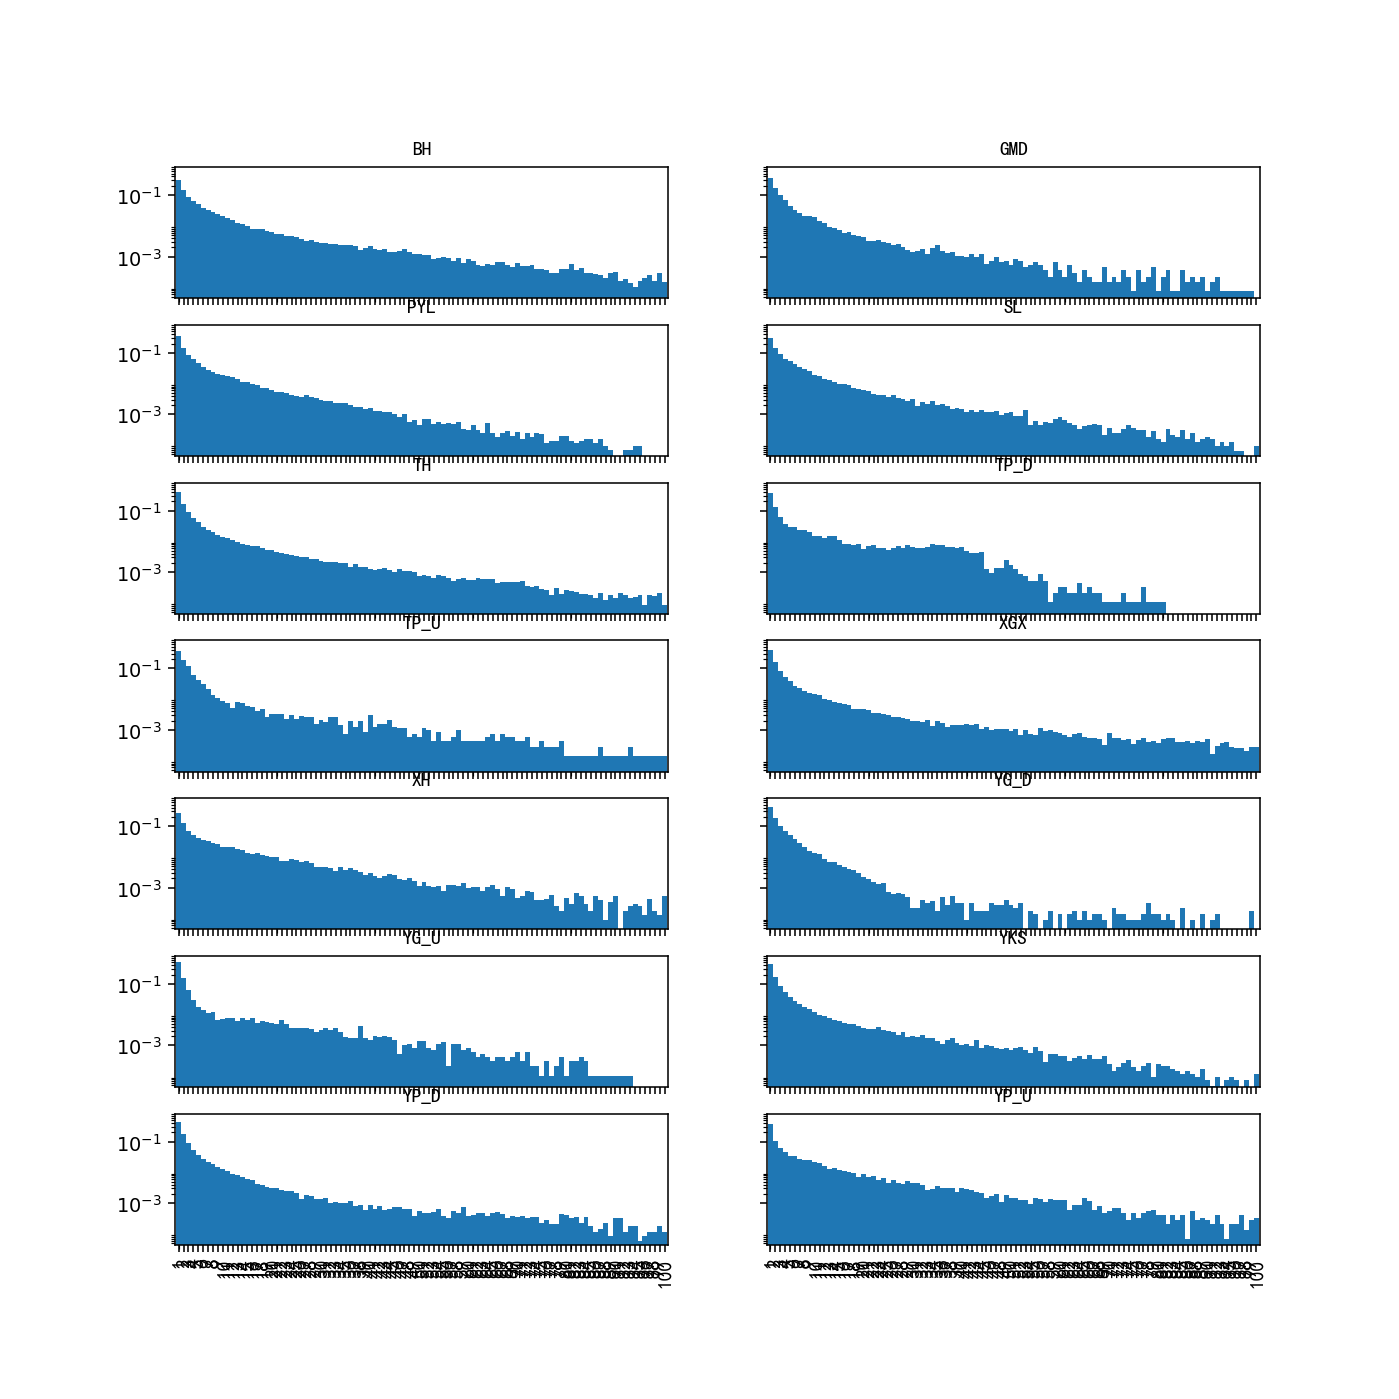

In [48]:
row,col=7,2
fig, axes = plt.subplots(row, col,sharex=True,sharey=True,figsize=[10,10])
for i in range(len(area)):
    temp=x[x.area_id_prev==area.area_id[i]]
    temp.stay.value_counts(normalize=True).sort_index()[:100].plot(kind='bar',ax=axes[i/col][i%col],logy=True,width=1)
    axes[i/col][i%col].set_title(area.area[i])

<IPython.core.display.Javascript object>


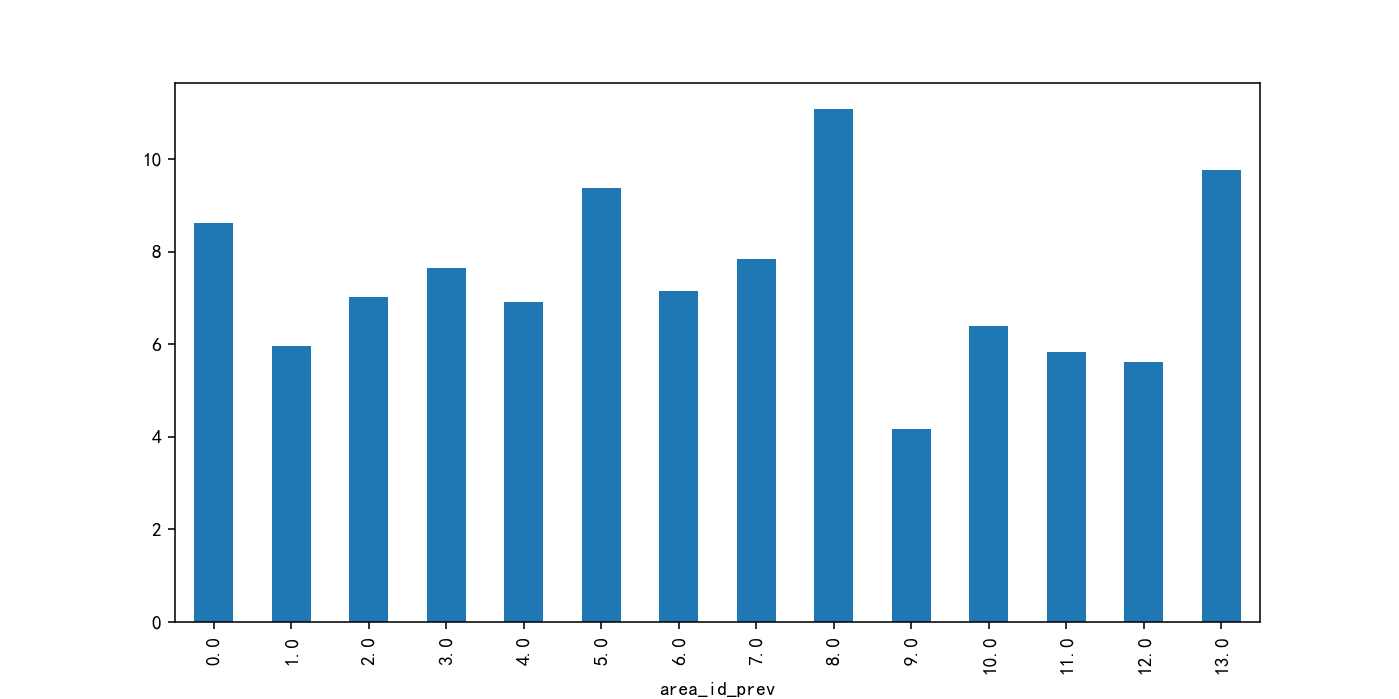

In [49]:
x.groupby('area_id_prev')['stay'].apply(np.mean).plot(kind='bar')

<IPython.core.display.Javascript object>


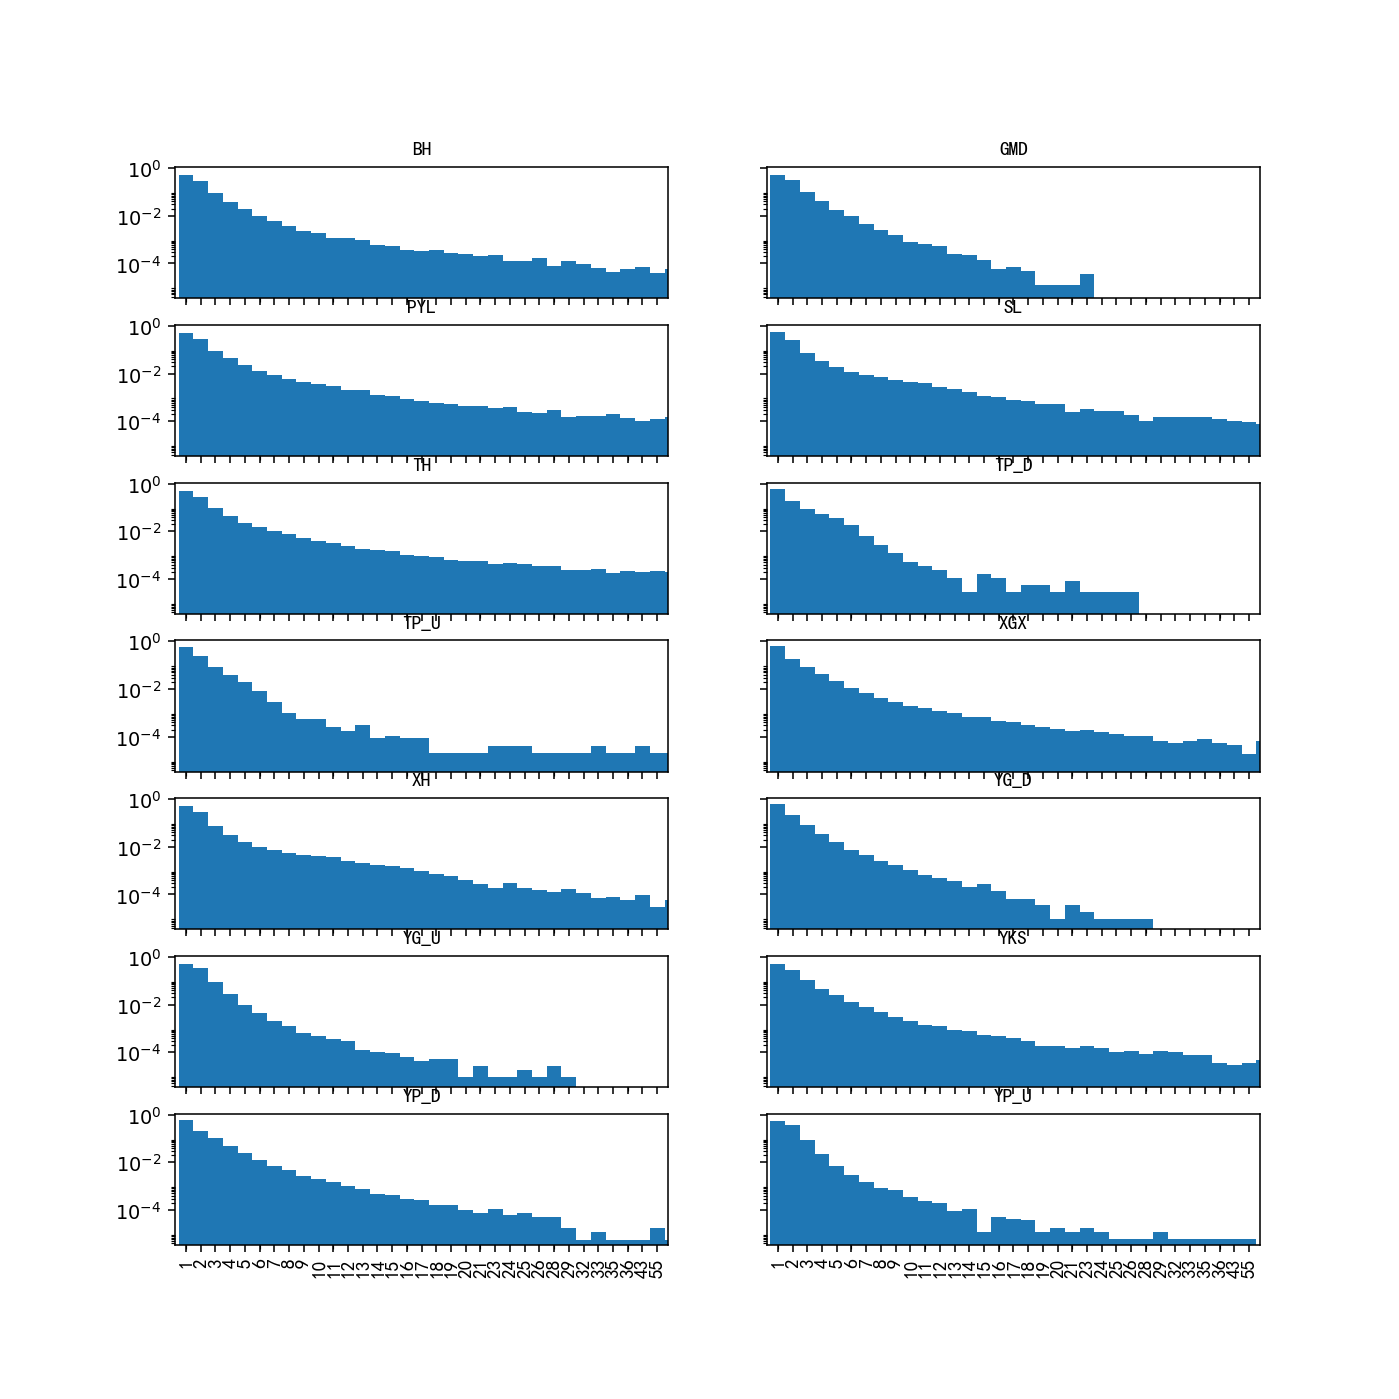

In [50]:
row,col=7,2
fig, axes = plt.subplots(row, col,sharex=True,sharey=True,figsize=[10,10])
for i in range(len(area)):
    temp=trace_detime[trace_detime.area_id==area.area_id[i]]
    temp.stay.value_counts(normalize=True).sort_index().plot(kind='bar',ax=axes[i/col][i%col],logy=True,width=1)
    axes[i/col][i%col].set_title(area.area[i])

<IPython.core.display.Javascript object>


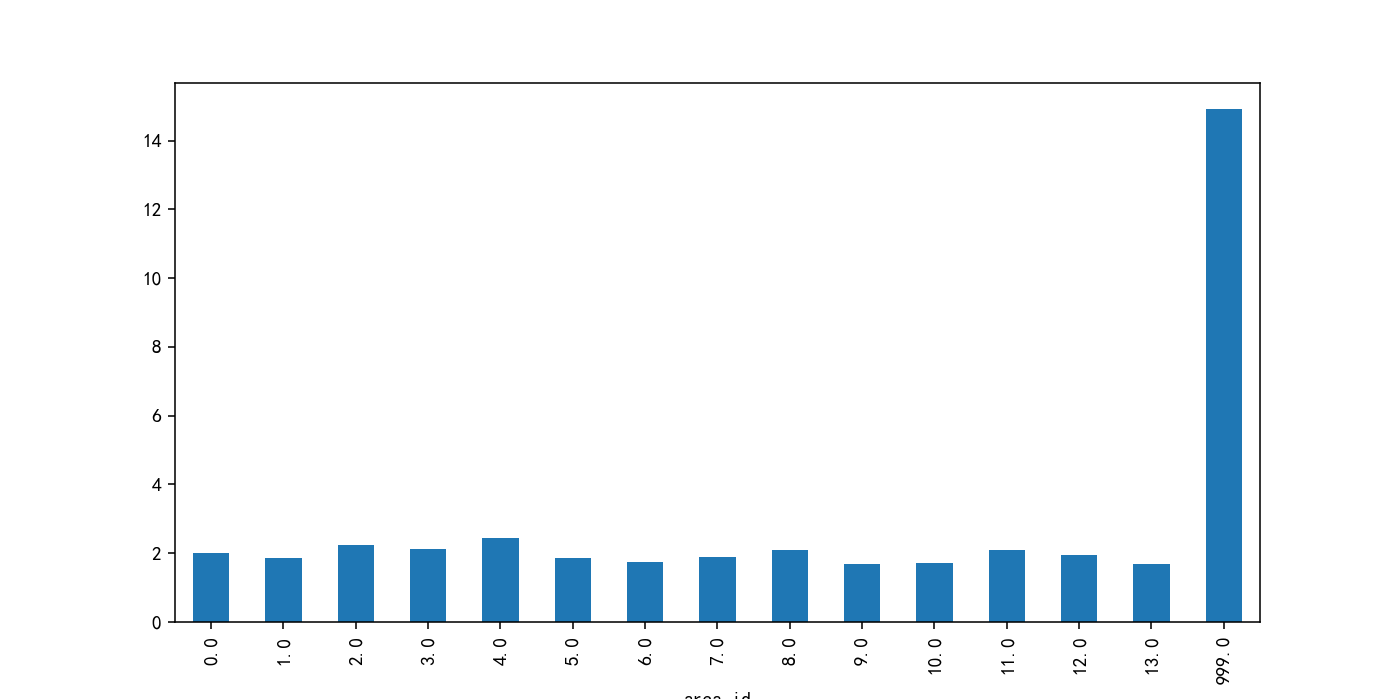

In [51]:
trace_detime.groupby('area_id')['stay'].apply(np.mean).plot(kind='bar')

In [53]:
purge_threshold=6  #the threshold tw to fill na
mask=((trace_detime.area_id_next==trace_detime.area_id_prev) & 
               (trace_detime.area_id==999) & 
               (trace_detime.stay<=purge_threshold))
trace_pd=trace_detime.copy()
trace_pd.loc[trace_detime[mask].index, 'area_id']=trace_detime.area_id_prev[mask]

In [55]:
def run_length_compress(trace):
    import itertools as itt
    def f(group):
        in_tw=group.in_tw.values[0]
        result=pd.DataFrame([[k,sum([i[1] for i in g])] 
                             for k,g in itt.groupby(group.loc[:,['area_id','stay']].values,lambda x: x[0])],
                            columns=['area_id','stay'])
        result['in_tw']=in_tw
        result['area_id_prev']=result.area_id.shift(1)
        result['area_id_next']=result.area_id.shift(-1)
        result.index.name='ith'
        return result
    trace=trace.groupby(['mac','date']).apply(f).reset_index()
    return trace
trace_pd=run_length_compress(trace_pd)

trace_pd.to_csv(folder+'/data/trace_pd_6tw.csv',index=False,header=True)

<IPython.core.display.Javascript object>


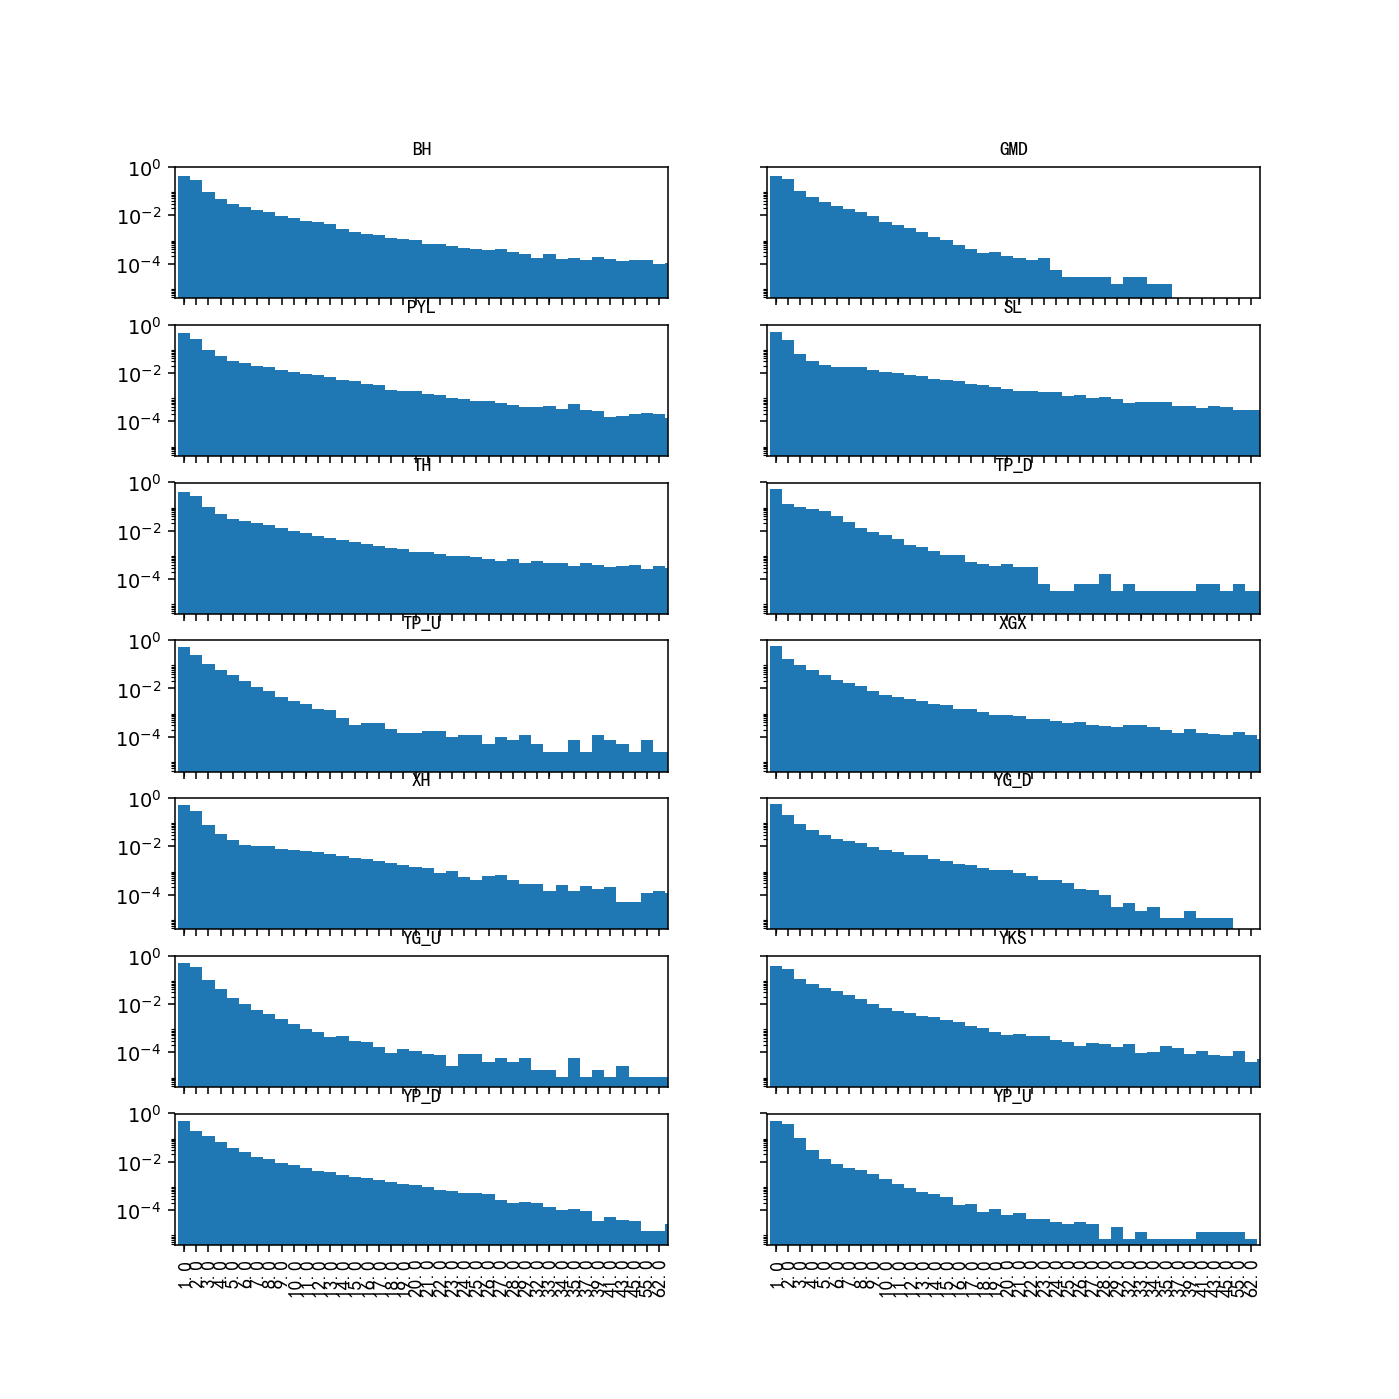

In [54]:
row,col=7,2
fig, axes = plt.subplots(row, col,sharex=True,sharey=True,figsize=[10,10])
for i in range(len(area)):
    temp=trace_pd[trace_pd.area_id==area.area_id[i]]
    temp.stay.value_counts(normalize=True).sort_index().plot(kind='bar',ax=axes[i/col][i%col],logy=True,width=1)
    axes[i/col][i%col].set_title(area.area[i])

<IPython.core.display.Javascript object>


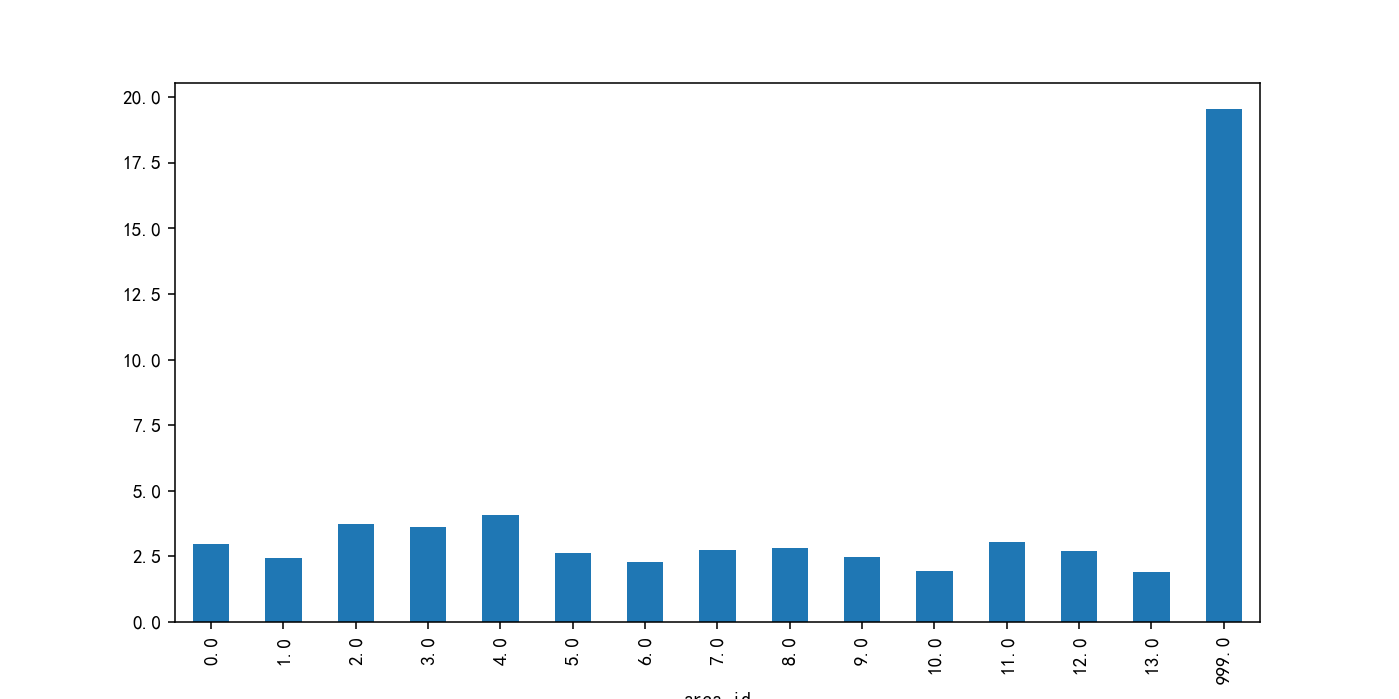

In [53]:
trace_pd.groupby('area_id')['stay'].apply(np.mean).plot(kind='bar')

填补之后短时停留基本不变，长时停留比例增加，导致平均停留时长增加（可考虑进行分解）

#### 2. 跳跃点观察

In [52]:
trace_pd=pd.read_csv(folder+'/data/trace_pd_6tw_jump.csv')
trace_pd['date'] = pd.to_datetime(trace_pd.date)
print len(trace_pd)
trace_pd.head()

2583168


mac       date  ith  area_id  stay  in_tw  area_id_prev  area_id_next
0  000000642951 2017-02-02    0     12.0   6.0    105           NaN         999.0
1  000000642951 2017-02-02    1    999.0  23.0    105          12.0          13.0
2  000000642951 2017-02-02    2     13.0   1.0    105         999.0         999.0
3  000000642951 2017-02-02    3    999.0   5.0    105          13.0          12.0
4  000000642951 2017-02-02    4     12.0   3.0    105         999.0           NaN

<IPython.core.display.Javascript object>


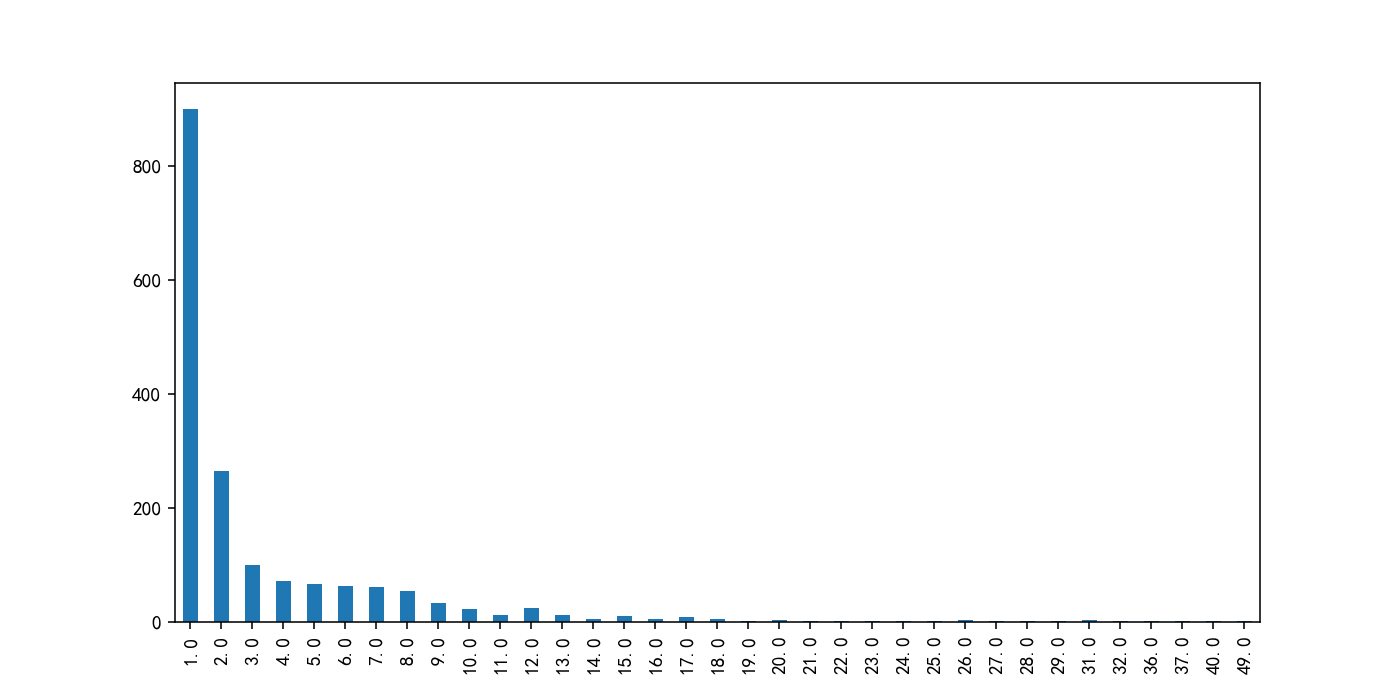

In [5]:
mask=((trace_pd.area_id_next==trace_pd.area_id_prev) & 
      (trace_pd.area_id_next!=trace_pd.area_id) &
      (trace_pd.area_id_prev!=999) &
      (trace_pd.area_id!=999))
trace_pd[mask].stay.value_counts().sort_index().plot(kind='bar')

In [8]:
def net_visualization(net,a='area_id_prev',b='area_id',weight='cnt',area=area):
    x1=area.x[net[a]].values
    x2=area.x[net[b]].values
    y1=area.y[net[a]].values
    y2=area.y[net[b]].values
    w=(net[weight]/float(net[weight].max())).values

    for i in range(len(net)):
        plt.plot([x1[i],x2[i]],[y1[i],y2[i]], alpha = 0.6, linewidth=w[i]*50);
    for i in range(len(area)):
        plt.text(area.x[i], area.y[i], area.area[i], color='darkred')
    #plt.scatter(area_stay.x, area_stay.y, s=np.sqrt(area_stay.cnt)*10, c=area_stay.cnt, cmap='jet', linewidth=0)

<IPython.core.display.Javascript object>


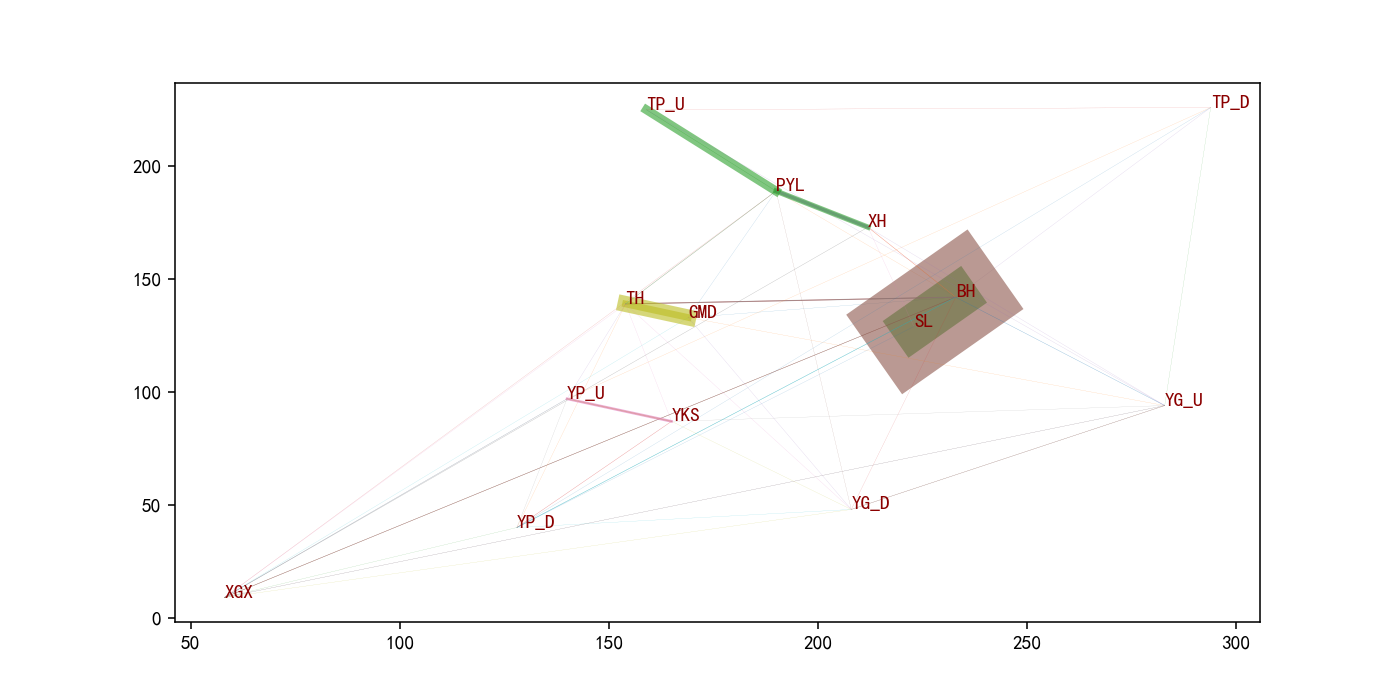

In [9]:
net_visualization(trace_pd[mask&(trace_pd.stay<=3)].groupby(['area_id','area_id_prev']).size().reset_index(name='cnt'))

In [ ]:
purge_threshold=3
i=0
def adjustAP(group):
    group=group.drop(['mac','date'],axis=1)
    while True:
        mask=((group.area_id_next==group.area_id_prev) & 
              (group.area_id_next!=group.area_id) &
              (group.area_id_prev!=999) &
              (group.area_id!=999) &
              (group.stay<=purge_threshold))
        if len(group[mask])==0:
            global i
            i+=1
            if i%(100000)==1:
                print i
            return group
        #group.loc[group[mask].index, 'area_id']=group.area_id_prev[mask]
        group['area_id']=np.where(mask, group.area_id_prev, group.area_id)
        group['area_id_prev']=group.area_id.shift(1)
        group['area_id_next']=group.area_id.shift(-1)
        

    #return group
trace_pd=trace_pd.groupby(['mac','date']).apply(adjustAP)  

In [9]:
purge_threshold=3

r=[]
i=0 
for n,group in trace_pd.groupby(['mac','date']):
    
    if i%(10000)==1:
        print i
    if i%(100000)==1:
        pd.concat(r,ignore_index=True).to_csv(folder+'/data/trace_pd_piece/%d.csv'%i,index=False,header=True)
        r=[]
        print 'writing file %d'%i
    
    group=group.copy()
    while True:
        mask=((group.area_id_next==group.area_id_prev) & 
              (group.area_id_next!=group.area_id) &
              (group.area_id_prev!=999) &
              (group.area_id!=999) &
              (group.stay<=purge_threshold))
        if len(group[mask])==0:
            break
        group['area_id']=np.where(mask, group.area_id_prev, group.area_id)
        #group.loc[group[mask].index, 'area_id']=group.area_id_prev[mask]
        group['area_id_prev']=group.area_id.shift(1)
        group['area_id_next']=group.area_id.shift(-1)
        
    r.append(group)
    i+=1

pd.concat(r,ignore_index=True).to_csv(folder+'/data/trace_pd_piece/%d.csv'%i,index=False,header=True)

1
writing file 1
10001
20001
30001
40001
50001
60001
70001
80001
90001
100001
writing file 100001
110001
120001
130001
140001
150001
160001
170001
180001
190001
200001
writing file 200001
210001
220001
230001
240001
250001
260001
270001
280001
290001
300001
writing file 300001
310001
320001
330001
340001
350001
360001
370001
380001
390001
400001
writing file 400001
410001
420001
430001
440001
450001
460001
470001
480001
490001
500001
writing file 500001
510001
520001
530001
540001
550001
560001
570001
580001
590001
600001
writing file 600001
610001
620001


In [35]:
r=[]
for f in os.listdir(folder+'/data/trace_pd_piece'):
    r.append(pd.read_csv(folder+'/data/trace_pd_piece/'+f,dtype={'mac':'str'}))
trace_pd=pd.concat(r,ignore_index=True)

In [40]:
def run_length_compress(trace):
    import itertools as itt
    def f(group):
        in_tw=group.in_tw.values[0]
        result=pd.DataFrame([[k,sum([i[1] for i in g])] 
                             for k,g in itt.groupby(group.loc[:,['area_id','stay']].values,lambda x: x[0])],
                            columns=['area_id','stay'])
        result['in_tw']=in_tw
        result['area_id_prev']=result.area_id.shift(1)
        result['area_id_next']=result.area_id.shift(-1)
        result.index.name='ith'
        return result
    trace=trace.groupby(['mac','date']).apply(f).reset_index()
    return trace
trace_pd=run_length_compress(trace_pd)

trace_pd.to_csv(folder+'/data/trace_pd_6tw.csv',index=False,header=True)

# Trace analysis

In [17]:
#载入ap点位
ap = pd.read_csv(folder+'/map&info/AP.csv', encoding='gbk')
ap.location = ap.location.astype(str)
#不同区域的代码，同一区域可能有多个ap
area = pd.read_csv(folder+'/map&info/area.csv', encoding='gbk')
area.area = area.area.astype(str)
ap = pd.merge(ap, area).sort_values('ap_seq')
ap

ap_seq      ap       location  area location_C    x    y  area_id
0        0  C0AA40    YKS_dinning   YKS     迎客松_餐厅  165   87       11
2        1  C0AA42        YG_down  YG_D       云谷_下  208   48        9
3        2  C0AA4C  XGX_reception   XGX     新国线_前台   58    9        7
4        3  C0AA4E     XGX_ticket   XGX     新国线_售票   58    9        7
5        4  C0AA50          YG_up  YG_U       云谷_上  283   94       10
1        5  C0AA56  YKS_reception   YKS     迎客松_前台  165   87       11
6        6  C0AA5A          YP_up  YP_U       玉屏_上  140   97       13
7        7  C0AA64         XH_bar    XH      西海_吧台  212  173        8
9        8  C327DA            GMD   GMD        光明顶  169  133        1
8        9  C327DE   XH_reception    XH      西海_前台  212  173        8
10      10  C327E2             SL    SL         狮林  223  129        3
11      11  C327E8            PYL   PYL        排云楼  190  189        2
12      12  C327F0          TP_up  TP_U       太平_上  159  225        6
13      13  C327F4   BH_reception    BH      北海_前台  233  142        0
15      14  C3287A       YP_down0  YP_D      玉屏_下入  128   40       12
16      15  C55E0A       YP_down1  YP_D      玉屏_下票  128   40       12
17      16  C55E4A          TH_by    TH      天海_白云  154  139        4
18      17  C55E76        TH_bld3    TH     天海_3号楼  154  139        4
19      18  C64F74        TP_down  TP_D       太平_下  294  226        5
14      19  CF5C6E       BH_plaza    BH      北海_广场  233  142        0

In [16]:
trace_pd=pd.read_csv(folder+'/data/trace_pd_6tw.csv')
trace_pd['date'] = pd.to_datetime(trace_pd.date)
print len(trace_pd)
trace_pd.head()

2580778


mac       date  ith  area_id  stay  in_tw  area_id_prev  area_id_next
0  000000642951 2017-02-02    0     12.0   6.0    105           NaN         999.0
1  000000642951 2017-02-02    1    999.0  23.0    105          12.0          13.0
2  000000642951 2017-02-02    2     13.0   1.0    105         999.0         999.0
3  000000642951 2017-02-02    3    999.0   5.0    105          13.0          12.0
4  000000642951 2017-02-02    4     12.0   3.0    105         999.0           NaN

In [18]:
# transfrom to {'stay','gap'} format
trace_pd['gap']=np.where(trace_pd.shift(-1).area_id==999,trace_pd.shift(-1).stay,0)
trace_pd['gap']=np.where(trace_pd.area_id_next.isnull(),np.nan,trace_pd.gap)

trace_pd=trace_pd[trace_pd.area_id!=999].copy()
trace_pd['area_id_prev']=np.where(trace_pd.area_id_prev.notnull(),trace_pd.area_id.shift(1),np.nan)
trace_pd['area_id_next']=np.where(trace_pd.area_id_next.notnull(),trace_pd.area_id.shift(-1),np.nan)
print len(trace_pd)
trace_pd.head()

1620396


mac       date  ith  area_id  stay  in_tw  area_id_prev  area_id_next   gap
0  000000642951 2017-02-02    0     12.0   6.0    105           NaN          13.0  23.0
2  000000642951 2017-02-02    2     13.0   1.0    105          12.0          12.0   5.0
4  000000642951 2017-02-02    4     12.0   3.0    105          13.0           NaN   NaN
5  00000071AF83 2017-01-30    0     12.0   2.0    142           NaN          13.0   7.0
7  00000071AF83 2017-01-30    2     13.0   1.0    142          12.0          12.0  28.0

<IPython.core.display.Javascript object>


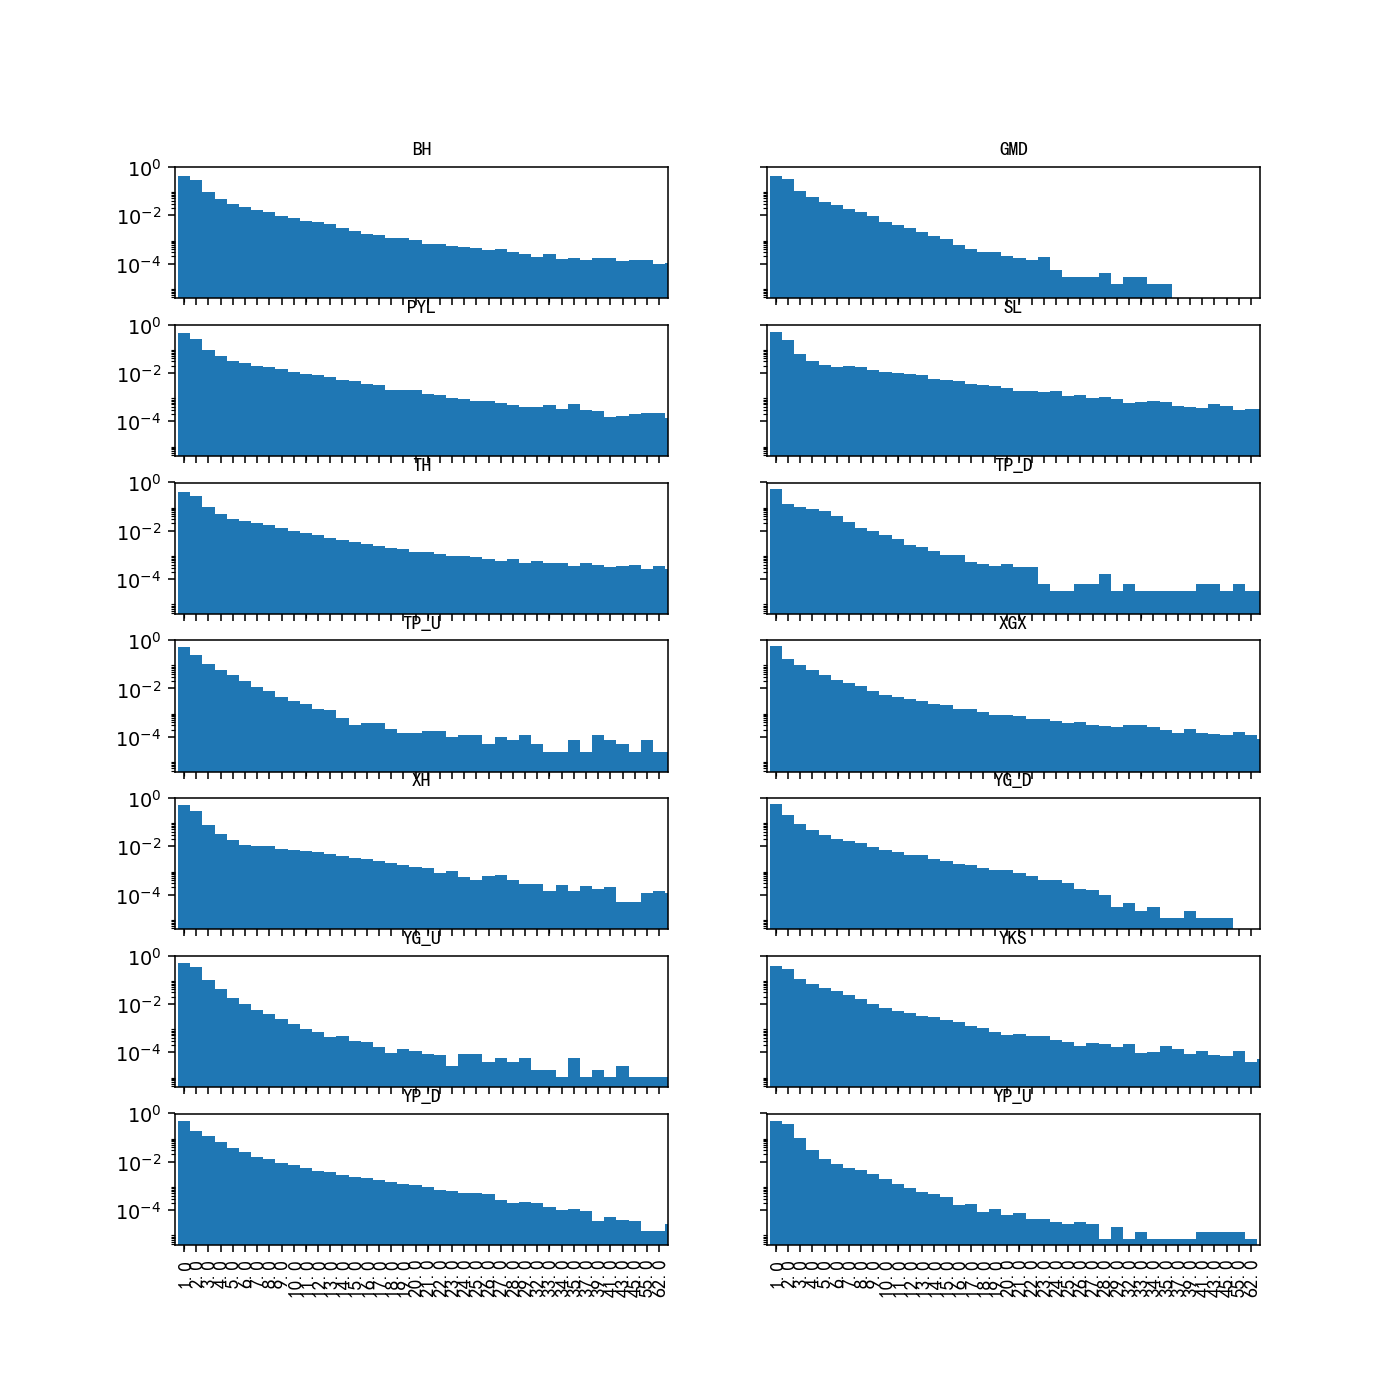

In [8]:
row,col=7,2
fig, axes = plt.subplots(row, col,sharex=True,sharey=True,figsize=[10,10])
for i in range(len(area)):
    temp=trace_pd[trace_pd.area_id==area.area_id[i]]
    temp.stay.value_counts(normalize=True).sort_index().plot(kind='bar',ax=axes[i/col][i%col],logy=True,width=1)
    axes[i/col][i%col].set_title(area.area[i])

#### 路径分析

In [4]:
attr=pd.read_csv(folder+'/data/attr.csv')
attr['date'] = pd.to_datetime(attr.date)
print len(attr)
attr.head()

3544163


mac       date  arr_ap  dept_ap  num_area  num_loc  num_tw  tmax  tmin     type     up             vendor
0  00000000E254 2017-02-07      14       15         1        2       2    88    87  visitor  False  XEROX CORPORATION
1  0000000145B0 2017-02-02       2        2         1        1       2   115   114  visitor  False  XEROX CORPORATION
2  00000001BD0B 2017-02-01      14       14         1        1       9   172   151  visitor  False  XEROX CORPORATION
3  000000087A4D 2017-01-24       1       15         2        2       3   189   112  visitor  False  XEROX CORPORATION
4  0000005F09D1 2017-01-30      14       14         1        1       1   207   207  visitor  False  XEROX CORPORATION

<IPython.core.display.Javascript object>


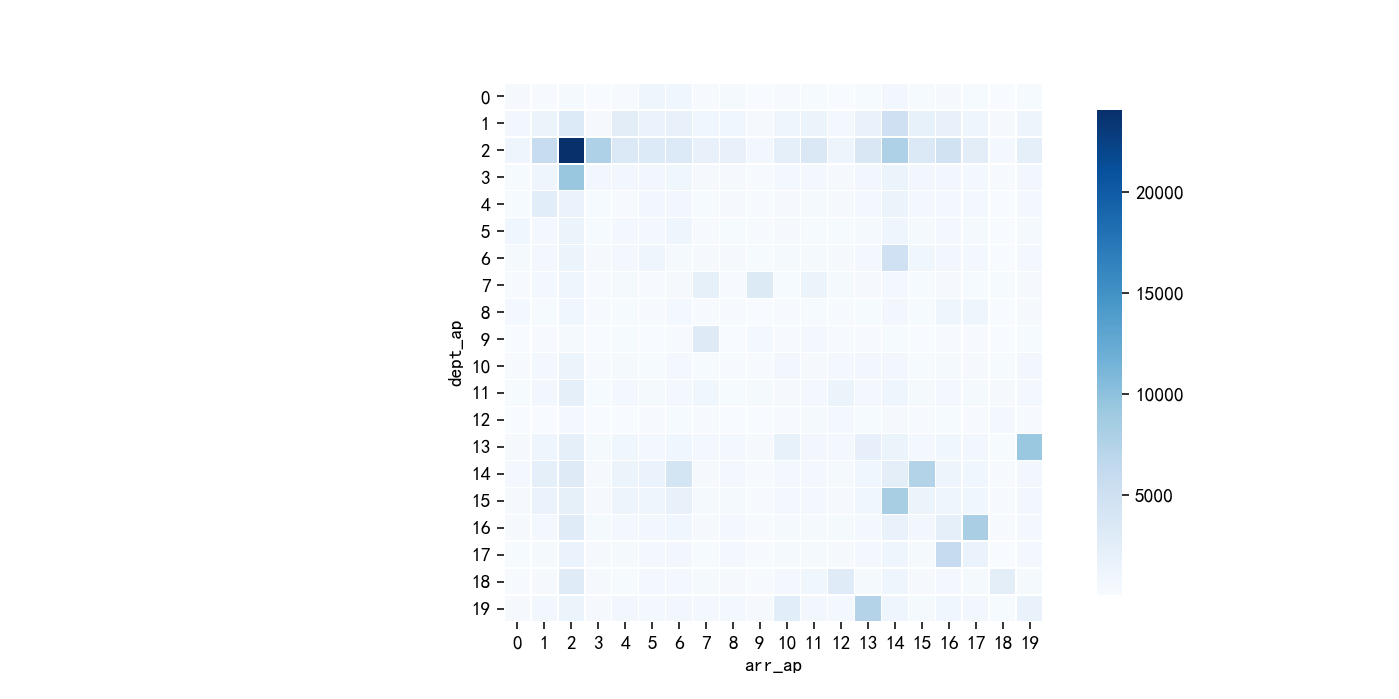

In [9]:
#起止点
cmap = 'Blues'
sns.heatmap(attr[attr.num_loc>1].groupby(['arr_ap','dept_ap']).size().reset_index(name='cnt').pivot('arr_ap','dept_ap','cnt'), cmap=cmap, 
            square=True, 
            linewidths=.2, cbar_kws={"shrink": .9})
plt.yticks(rotation=0)
plt.xlabel(u'arr_ap')
plt.ylabel(u'dept_ap')

流量分析

<IPython.core.display.Javascript object>


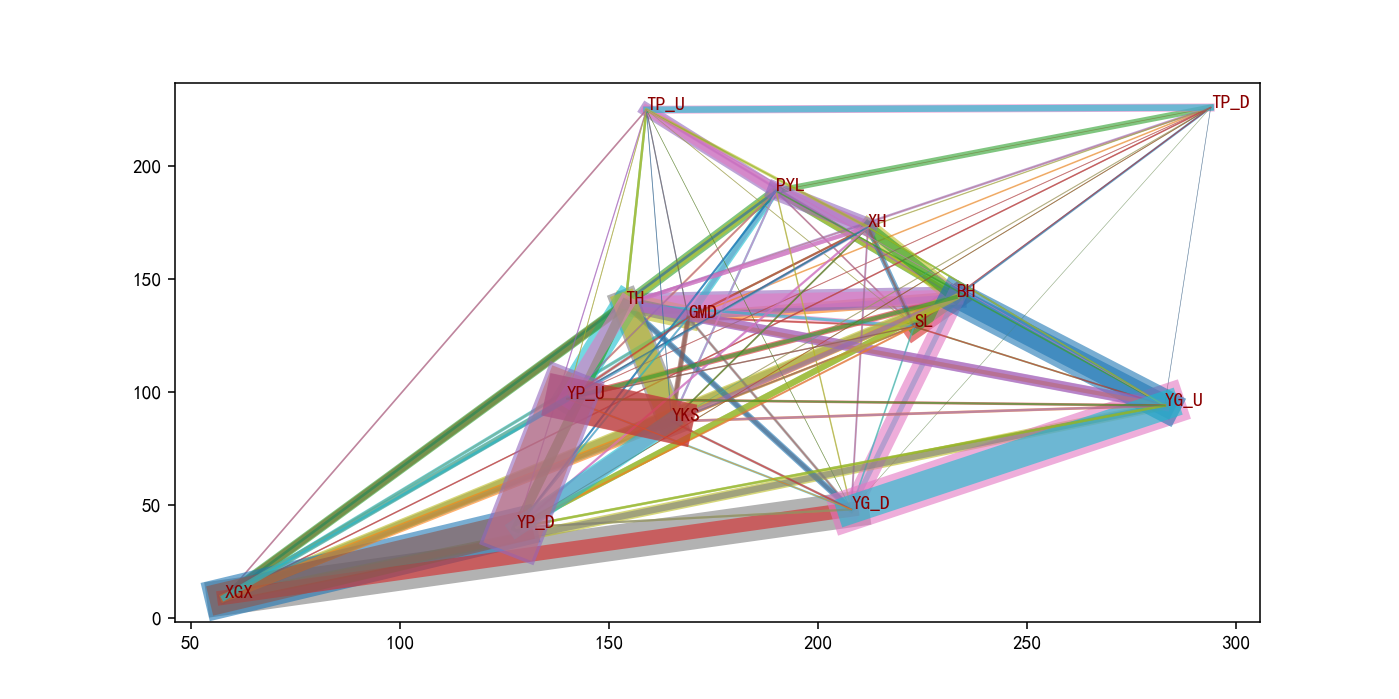

In [10]:
def net_visualization(net,a='area_id_prev',b='area_id',weight='cnt',area=area):
    x1=area.x[net[a]].values
    x2=area.x[net[b]].values
    y1=area.y[net[a]].values
    y2=area.y[net[b]].values
    w=(net[weight]/float(net[weight].max())).values

    for i in range(len(net)):
        plt.plot([x1[i],x2[i]],[y1[i],y2[i]], alpha = 0.6, linewidth=w[i]*30);
    for i in range(len(area)):
        plt.text(area.x[i], area.y[i], area.area[i], color='darkred')
    #plt.scatter(area_stay.x, area_stay.y, s=np.sqrt(area_stay.cnt)*10, c=area_stay.cnt, cmap='jet', linewidth=0)
    

net_visualization(trace_pd.groupby(['area_id','area_id_next']).size().reset_index(name='cnt'),a='area_id',b='area_id_next')

<IPython.core.display.Javascript object>


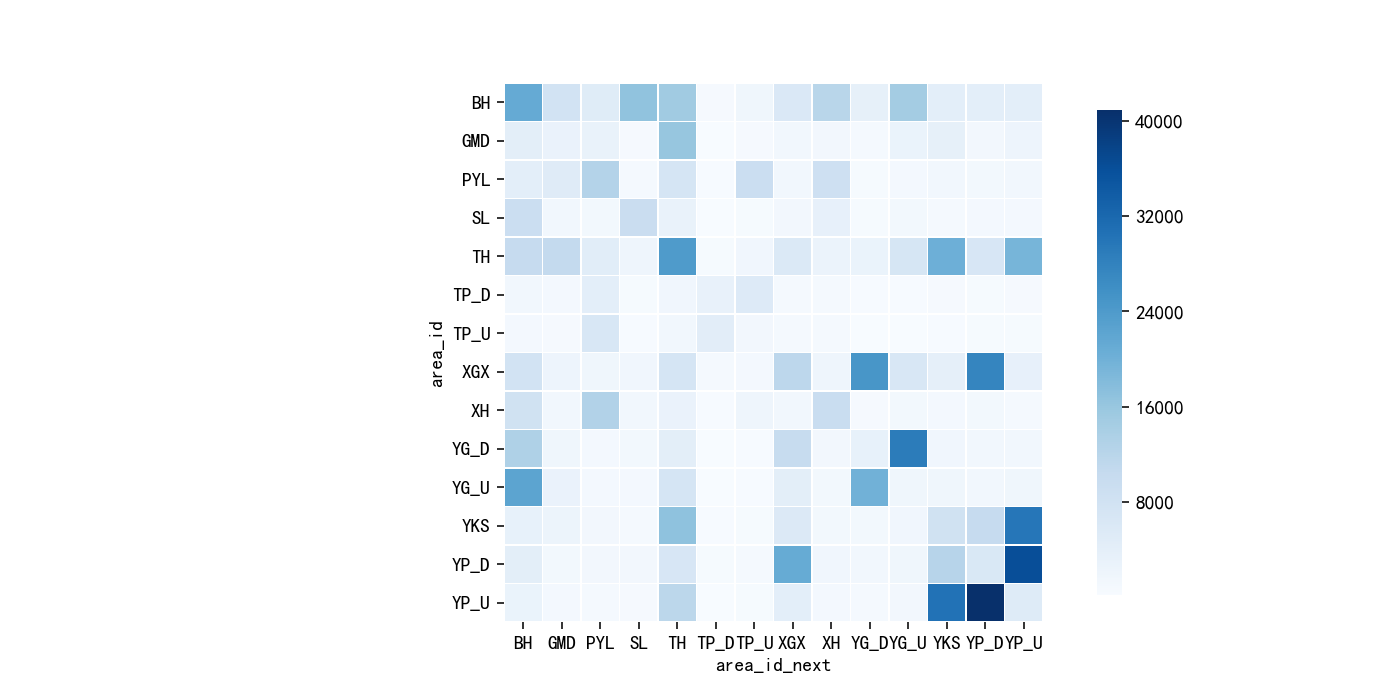

In [11]:
cmap = 'Blues'
sns.heatmap(trace_pd.groupby(['area_id','area_id_next']).size().reset_index(name='cnt').pivot('area_id','area_id_next','cnt'), cmap=cmap, 
            square=True, 
            linewidths=.2, cbar_kws={"shrink": .9})

l,t=plt.xticks(rotation=0)
t=area.area.values
plt.xticks(l,t)
l,t=plt.yticks(rotation=0)
t=area.area.values[::-1]
plt.yticks(l,t);

路径时长

<IPython.core.display.Javascript object>


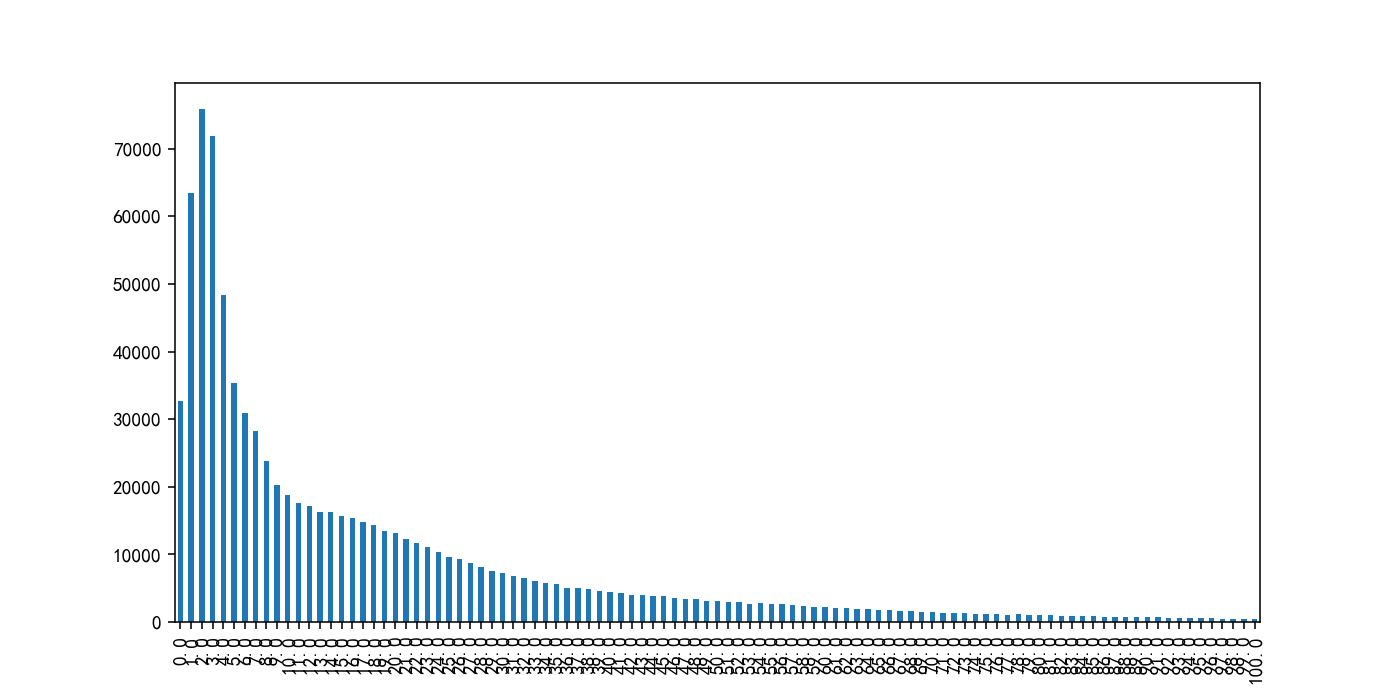

In [13]:
trace_pd[trace_pd.area_id!=trace_pd.area_id_next].gap.value_counts().sort_index()[:100].plot(kind='bar')

In [64]:
def net_visualization(net,a='area_id_prev',b='area_id',weight='cnt',area=area):
    x1=area.x[net[a]].values
    x2=area.x[net[b]].values
    y1=area.y[net[a]].values
    y2=area.y[net[b]].values
    w=(net[weight]/float(net[weight].max())).values

    for i in range(len(net)):
        plt.plot([x1[i],x2[i]],[y1[i],y2[i]], alpha = 0.6, linewidth=w[i]*10);
    for i in range(len(area)):
        plt.text(area.x[i], area.y[i], area.area[i], color='darkred')
    #plt.scatter(area_stay.x, area_stay.y, s=np.sqrt(area_stay.cnt)*10, c=area_stay.cnt, cmap='jet', linewidth=0)
    

net_visualization(trace_pd.groupby(['area_id','area_id_next']).gap.mean().reset_index(name='cnt'),a='area_id',b='area_id_next')

<IPython.core.display.Javascript object>


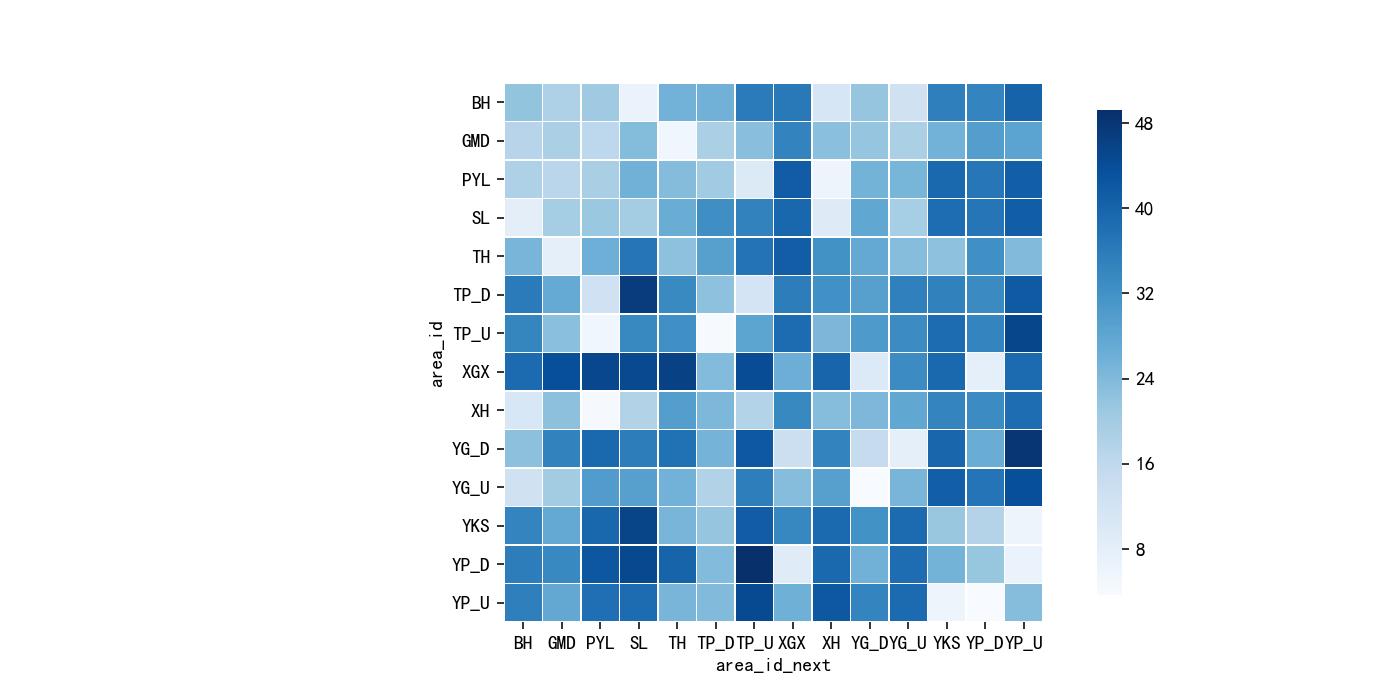

In [14]:
cmap = 'Blues'
sns.heatmap(trace_pd.groupby(['area_id','area_id_next']).gap.mean().reset_index(name='cnt').pivot('area_id','area_id_next','cnt'), cmap=cmap, 
            square=True, 
            linewidths=.2, cbar_kws={"shrink": .9})

l,t=plt.xticks(rotation=0)
t=area.area.values
plt.xticks(l,t)
l,t=plt.yticks(rotation=0)
t=area.area.values[::-1]
plt.yticks(l,t);

频繁路径

In [29]:
path=trace_pd.groupby(['mac','date'])['area_id'].apply(lambda x: list(x.values))
path=path.sort_index(level=['date','mac']).apply(lambda x: [int(i) for i in x]).apply(tuple).reset_index(name='path')
path=path[path.path.apply(len)>1]
#path=path[attr.set_index(['mac','day']).type!='device']
#path.to_csv(folder+'/data/path.csv',index=False,header=False)
print len(path)
path.head()

338509


mac       date          path
1  0008221D5A07 2017-01-19     (5, 2, 2)
2  000AF5F74BF0 2017-01-19  (11, 13, 12)
3  000CE7035938 2017-01-19  (11, 13, 12)
4  000CE707DD4B 2017-01-19      (11, 12)
5  00127B41619C 2017-01-19      (11, 11)

In [ ]:
os.chdir('F:/Research/weilai/scripts')
import PrefixSpan
minSupport=0.005
patterns = PrefixSpan.PrefixSpan(path.path.apply(lambda x:[[str(int(i))] for i in x if i!=999]),minSupport)
patterns = pd.DataFrame(patterns,columns=['Fp','support'])
patterns.support=patterns.support/float(len(path))
patterns.Fp=[[g[0] for g in f] for f in patterns.Fp]

In [78]:
import itertools as itt
patterns.Fp=[[g for g,_ in itt.groupby(f)] for f in patterns.Fp]

patterns.Fp=[tuple(f) for f in patterns.Fp]
patterns=patterns.groupby('Fp')['support'].apply(sum).reset_index(name='support')

In [79]:
patterns.sort_values('support',ascending=False)

Fp   support
709                      (7,)  0.473654
616                      (4,)  0.457701
0                        (0,)  0.439176
294                     (12,)  0.424263
455                     (13,)  0.368058
238                     (11,)  0.314571
1238                     (9,)  0.269659
139                     (10,)  0.249937
536                      (2,)  0.215297
1200                     (8,)  0.183514
356                  (12, 13)  0.157068
508                  (13, 12)  0.154463
99                       (1,)  0.153361
590                      (3,)  0.147792
867                   (7, 12)  0.143786
1035                   (7, 4)  0.132703
710                    (7, 0)  0.127308
974                   (7, 13)  0.123961
311                  (12, 11)  0.114047
1239                   (9, 0)  0.113752
450                   (12, 7)  0.109197
1073                   (7, 9)  0.108724
647                   (4, 13)  0.106818
1303                  (9, 10)  0.104538
645                   (4, 12)  0.104310
430                   (12, 4)  0.103542
64                     (0, 4)  0.103454
834                   (7, 11)  0.101129
662                    (4, 7)  0.099782
693                      (6,)  0.097017
...                       ...       ...
1226                (8, 2, 7)  0.005099
148         (10, 0, 1, 4, 13)  0.005096
1222           (8, 2, 13, 12)  0.005093
1188     (7, 9, 4, 11, 13, 7)  0.005090
521             (13, 4, 1, 9)  0.005087
1268             (9, 0, 3, 8)  0.005081
35            (0, 13, 11, 12)  0.005081
1110         (7, 9, 1, 4, 12)  0.005072
385   (12, 13, 11, 13, 4, 10)  0.005069
552                (2, 10, 7)  0.005069
1034                (7, 3, 8)  0.005060
1209               (8, 10, 7)  0.005057
887        (7, 12, 11, 12, 7)  0.005057
680                 (5, 2, 7)  0.005052
48              (0, 2, 4, 13)  0.005046
756            (7, 1, 11, 12)  0.005043
489           (13, 11, 13, 9)  0.005043
1399               (9, 2, 12)  0.005040
184           (10, 1, 11, 13)  0.005037
57             (0, 3, 13, 12)  0.005034
1377               (9, 10, 6)  0.005034
333        (12, 11, 13, 4, 9)  0.005034
958      (7, 12, 4, 0, 10, 9)  0.005031
147         (10, 0, 1, 4, 12)  0.005022
600               (3, 11, 12)  0.005022
588                 (2, 8, 9)  0.005019
410         (12, 13, 4, 0, 7)  0.005016
1133      (7, 9, 10, 0, 8, 2)  0.005004
494     (13, 11, 4, 0, 10, 9)  0.005001
548             (2, 1, 4, 11)  0.005001

[1430 rows x 2 columns]

In [80]:
patterns[patterns.Fp.apply(len)>3].sort_values('support',ascending=False)

Fp   support
940            (7, 12, 13, 4)  0.036687
916           (7, 12, 13, 11)  0.034422
388           (12, 13, 11, 4)  0.034008
641           (4, 11, 13, 12)  0.030466
893            (7, 12, 11, 4)  0.029080
414           (12, 13, 4, 10)  0.027258
1008           (7, 13, 12, 7)  0.027134
951            (7, 12, 13, 7)  0.026516
655            (4, 13, 12, 7)  0.026194
1114            (7, 9, 10, 0)  0.025598
1420           (9, 4, 13, 12)  0.025279
77             (0, 4, 13, 12)  0.023521
1369           (9, 10, 4, 12)  0.022945
1357          (9, 10, 13, 12)  0.022744
996            (7, 13, 11, 4)  0.022233
1322            (9, 10, 0, 4)  0.022032
260           (11, 13, 12, 7)  0.021799
1371           (9, 10, 4, 13)  0.021695
381          (12, 13, 11, 13)  0.021663
227           (10, 4, 13, 12)  0.021598
1150            (7, 9, 10, 4)  0.021441
926        (7, 12, 13, 11, 4)  0.021155
1058           (7, 4, 13, 12)  0.020954
344           (12, 11, 4, 10)  0.020584
847           (7, 11, 13, 12)  0.020044
1260           (9, 0, 13, 12)  0.019893
1275            (9, 0, 4, 12)  0.019695
1363           (9, 10, 4, 11)  0.019533
639            (4, 11, 12, 7)  0.018983
1277            (9, 0, 4, 13)  0.018924
...                       ...       ...
45             (0, 2, 13, 12)  0.005134
500     (13, 11, 4, 10, 9, 7)  0.005131
549             (2, 1, 4, 12)  0.005131
162             (10, 0, 2, 4)  0.005131
110        (1, 11, 13, 12, 7)  0.005128
279             (11, 4, 1, 9)  0.005122
258           (11, 13, 10, 9)  0.005120
1292       (9, 1, 11, 13, 12)  0.005108
1111         (7, 9, 1, 4, 13)  0.005105
148         (10, 0, 1, 4, 13)  0.005096
1222           (8, 2, 13, 12)  0.005093
1188     (7, 9, 4, 11, 13, 7)  0.005090
521             (13, 4, 1, 9)  0.005087
35            (0, 13, 11, 12)  0.005081
1268             (9, 0, 3, 8)  0.005081
1110         (7, 9, 1, 4, 12)  0.005072
385   (12, 13, 11, 13, 4, 10)  0.005069
887        (7, 12, 11, 12, 7)  0.005057
48              (0, 2, 4, 13)  0.005046
756            (7, 1, 11, 12)  0.005043
489           (13, 11, 13, 9)  0.005043
184           (10, 1, 11, 13)  0.005037
57             (0, 3, 13, 12)  0.005034
333        (12, 11, 13, 4, 9)  0.005034
958      (7, 12, 4, 0, 10, 9)  0.005031
147         (10, 0, 1, 4, 12)  0.005022
410         (12, 13, 4, 0, 7)  0.005016
1133      (7, 9, 10, 0, 8, 2)  0.005004
548             (2, 1, 4, 11)  0.005001
494     (13, 11, 4, 0, 10, 9)  0.005001

[824 rows x 2 columns]

路径聚类

In [74]:
path_group=path.groupby('path').groups
pd.Series(path_group.keys()).to_csv(folder+'/data/path.csv',index=False,header=False)

算距离（等待。。。）

In [4]:
import scipy.sparse as sps

dist=[]
for f in os.listdir(folder+'/data/temp'):
    dist.append(sps.load_npz(folder+'/data/temp/'+f))

dist=sps.hstack(dist)
sps.save_npz(folder+'/data/path_distance',dist)

<IPython.core.display.Javascript object>


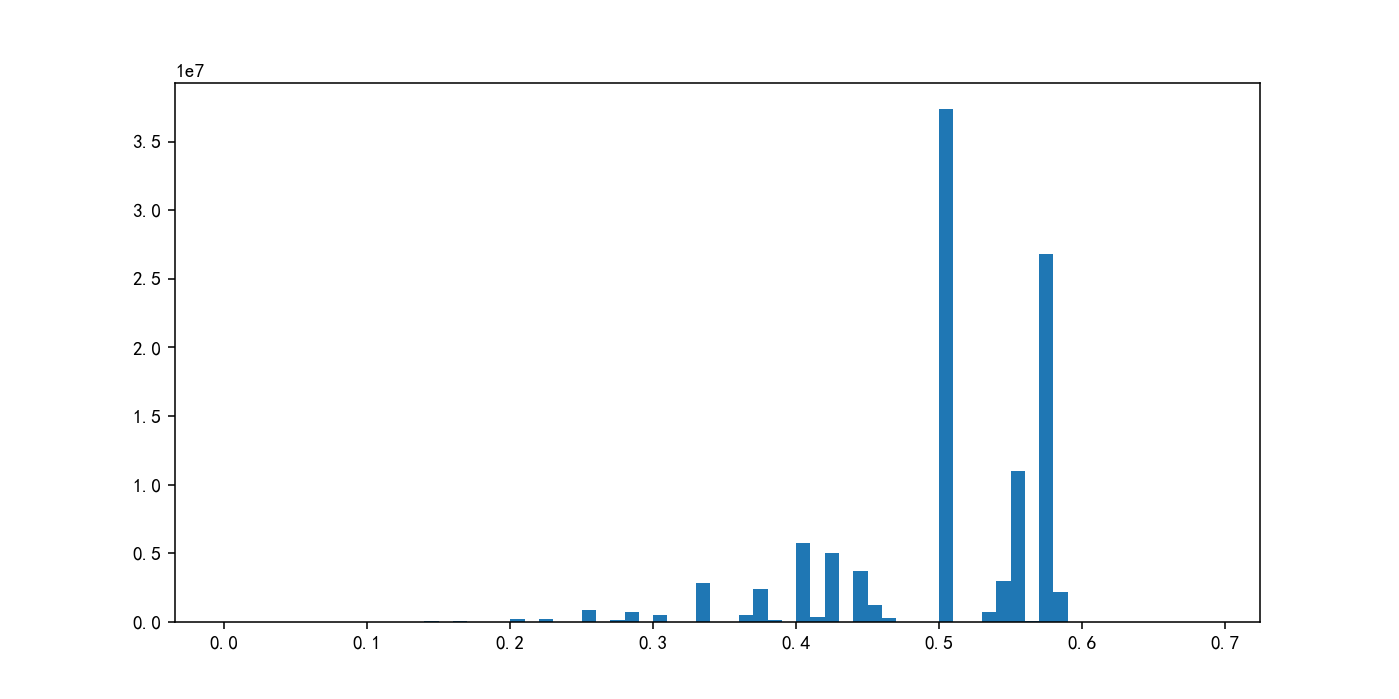

In [4]:
import scipy.sparse as sps
dist=sps.load_npz(folder+'/data/path_distance.npz')

plt.hist(dist.data,bins=np.arange(0,0.7,0.01));

In [5]:
#squareform for sparse matrix
def cal_loc(loc,dimension):
    row=np.floor(dimension-0.5-np.sqrt((2*dimension-1)**2-8*loc)/2)    
    temp = loc - row*(2*dimension-row-1)/2
    col = row + temp + 1
    return int(row),int(col)

def squareform(dist,start=0,end=None):
    s=dist.shape[1]
    dimension=int(np.ceil(np.sqrt(s*2)))
    if dimension*(dimension-1)/2!=s:
        print 'error'
        return
    m=sps.dok_matrix((dimension,dimension),dtype=np.float32) #this format is more spatially consuming
    if end is None:
        end=len(dist.data)
    for i in xrange(start,end):
        if i%100000==0:
            print i
        col=np.long(dist.col[i]) #To avoid overflow, this must be converted to 'long' format
        x,y=cal_loc(col,dimension)       
        m[x,y]=dist.data[i]
    return m

x=squareform(dist,start=60000000)
y=squareform(dist,end=60000000)

x=sps.csr_matrix(x)
sps.save_npz(folder+'/data/temp/dist2',x)
y=sps.load_npz(folder+'/data/temp/dist1.npz')
z=x+y

sps.save_npz(folder+'/data/dist_square',z)

<IPython.core.display.Javascript object>


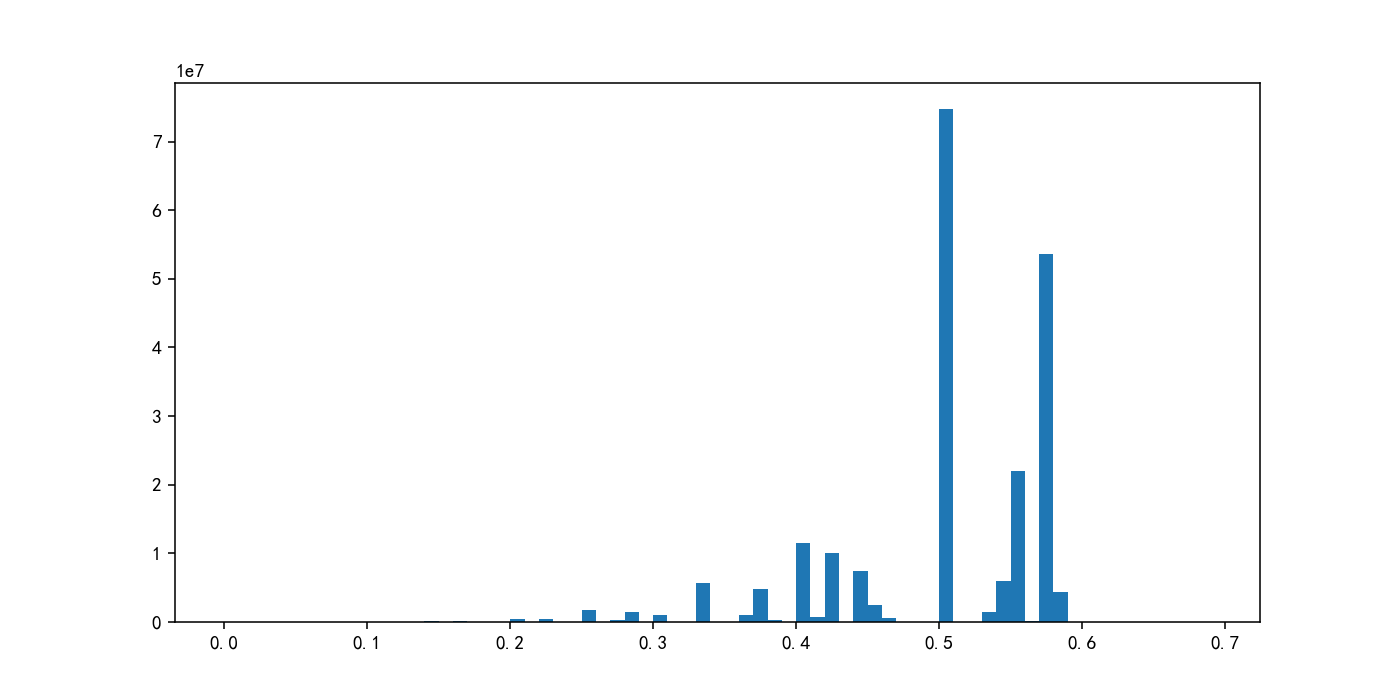

In [60]:
import scipy.sparse as sps
dist=sps.load_npz(folder+'/data/dist_square.npz')
dist=dist+dist.transpose()

plt.hist(dist.data,bins=np.arange(0,0.7,0.01));

In [ ]:
import scipy.cluster.hierarchy as sch
z=sch.linkage(dist,'average')
dg=sch.dendrogram(
    z,
    orientation='top',
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
#cluster_label=sch.fcluster(z,8,criterion='maxclust')

In [79]:
k=100
dist_sorted=[]
for i in range(dist.shape[0]):
    x=np.sort(dist.getrow(i).data)[:k]
    if len(x)<k:
        x=np.append(x,(np.zeros(k-len(x))+1))
    dist_sorted.append(x)

dist_sorted=np.vstack(dist_sorted)

<IPython.core.display.Javascript object>


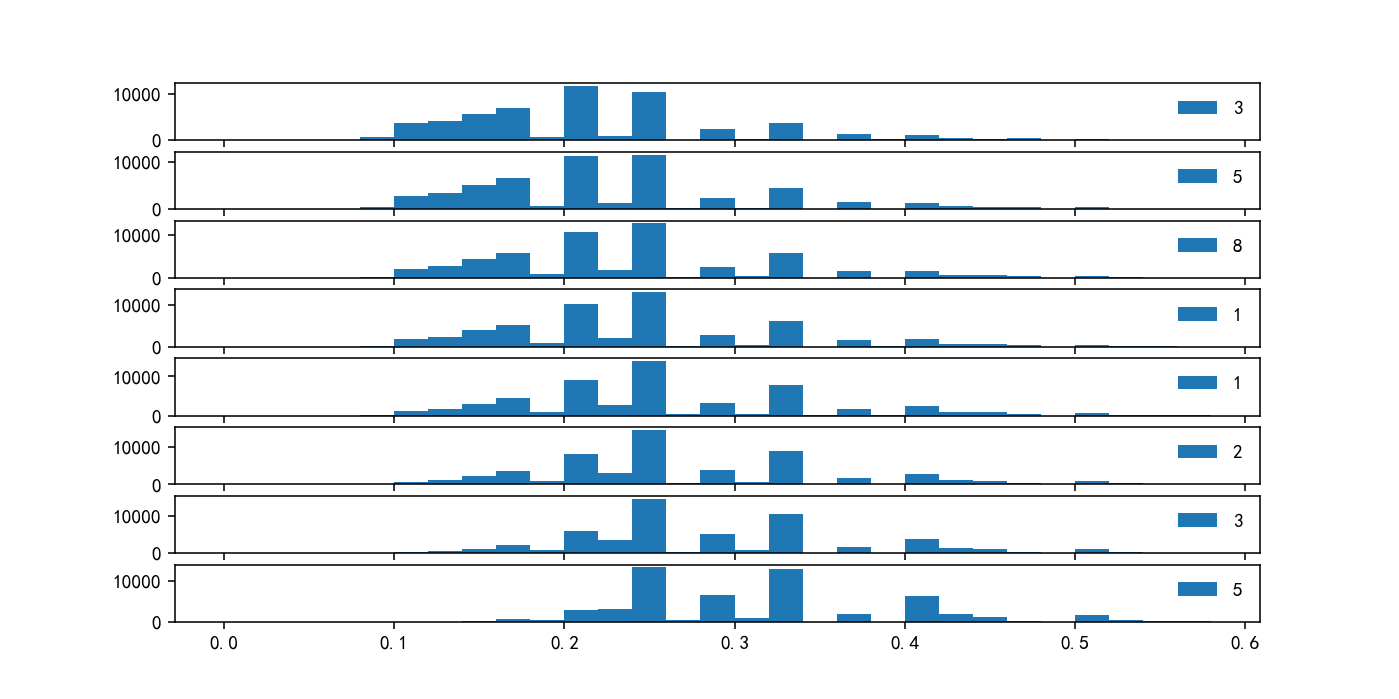

In [98]:
min_samples=[3,5,8,10,15,20,30,50]
fig,axes=plt.subplots(len(min_samples),sharex=True)
for i,s in enumerate(min_samples):
    axes[i].hist(dist_sorted[:,s],bins=np.arange(0,0.6,0.02));
    axes[i].legend('%s'%s,loc='best')

In [119]:
import sklearn.cluster as cluster
eps=0.1
min_samples=5
labels=cluster.DBSCAN(eps,min_samples,metric='precomputed').fit(dist).labels_

In [120]:
for l in set(labels):
    print l,sum(labels==l)

0 2270
1 1140
2 20
3 8
4 45
5 7
6 11
7 38
8 20
9 38
10 35
11 8
12 13
13 5
14 7
15 21
16 4
17 5
18 5
19 10
20 9
21 7
22 11
23 3
24 5
25 5
26 5
27 10
28 5
29 4
30 5
31 5
32 6
33 4
-1 52523


In [21]:
trace_completed=pd.read_csv(folder+'/data/trace_complete.csv')

In [14]:
d={'A':'10','B':'11','C':'12','D':'13'}
trace_completed.path.str.replace('.','').str.replace('E','').apply(list).apply(lambda x: [int(d[i]) if i in d else int(i) for i in x]).to_csv(folder+'/data/path_completed.csv',index=False,header=False)

In [4]:
import scipy.sparse as sps

for f in os.listdir(folder+'/data/temp'):
    try:
        dist=dist+sps.load_npz(folder+'/data/temp/'+f)
    except:
        dist=sps.load_npz(folder+'/data/temp/'+f)

sps.save_npz(folder+'/data/path_distance_completed',dist)

<IPython.core.display.Javascript object>


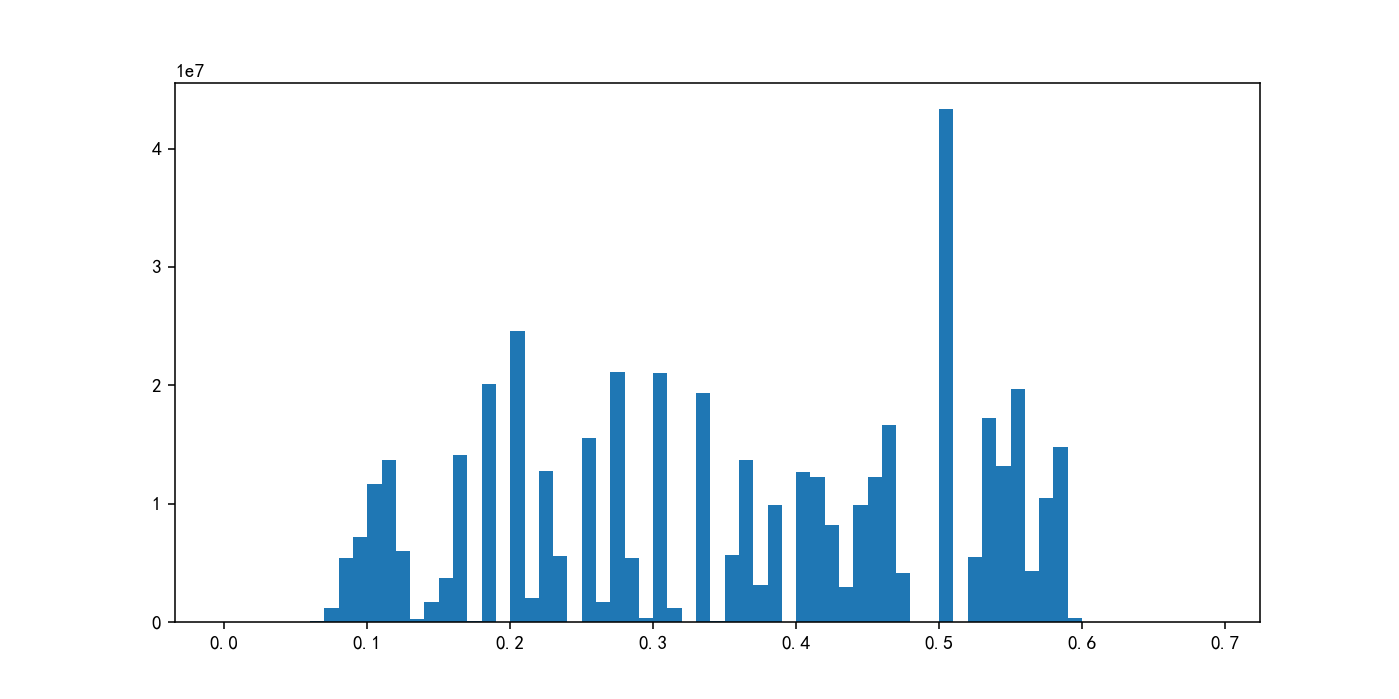

In [4]:
import scipy.sparse as sps
dist_completed=sps.load_npz(folder+'/data/path_distance_completed.npz')
dist_completed+=dist_completed.transpose()

plt.hist(dist_completed.data,bins=np.arange(0,0.7,0.01));

In [6]:
dist_completed=dist_completed.todense()

In [ ]:
import scipy.cluster.hierarchy as sch
z=sch.linkage(dist_completed,'average')
dg=sch.dendrogram(
    z,
    orientation='top',
    leaf_rotation=0.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
#cluster_label=sch.fcluster(z,8,criterion='maxclust')

In [6]:
k=100
dist_sorted=[]
for i in range(dist_completed.shape[0]):
    x=np.sort(dist_completed.getrow(i).data)[:k]
    if len(x)<k:
        x=np.append(x,(np.zeros(k-len(x))+1))
    dist_sorted.append(x)

dist_sorted=np.vstack(dist_sorted)

<IPython.core.display.Javascript object>


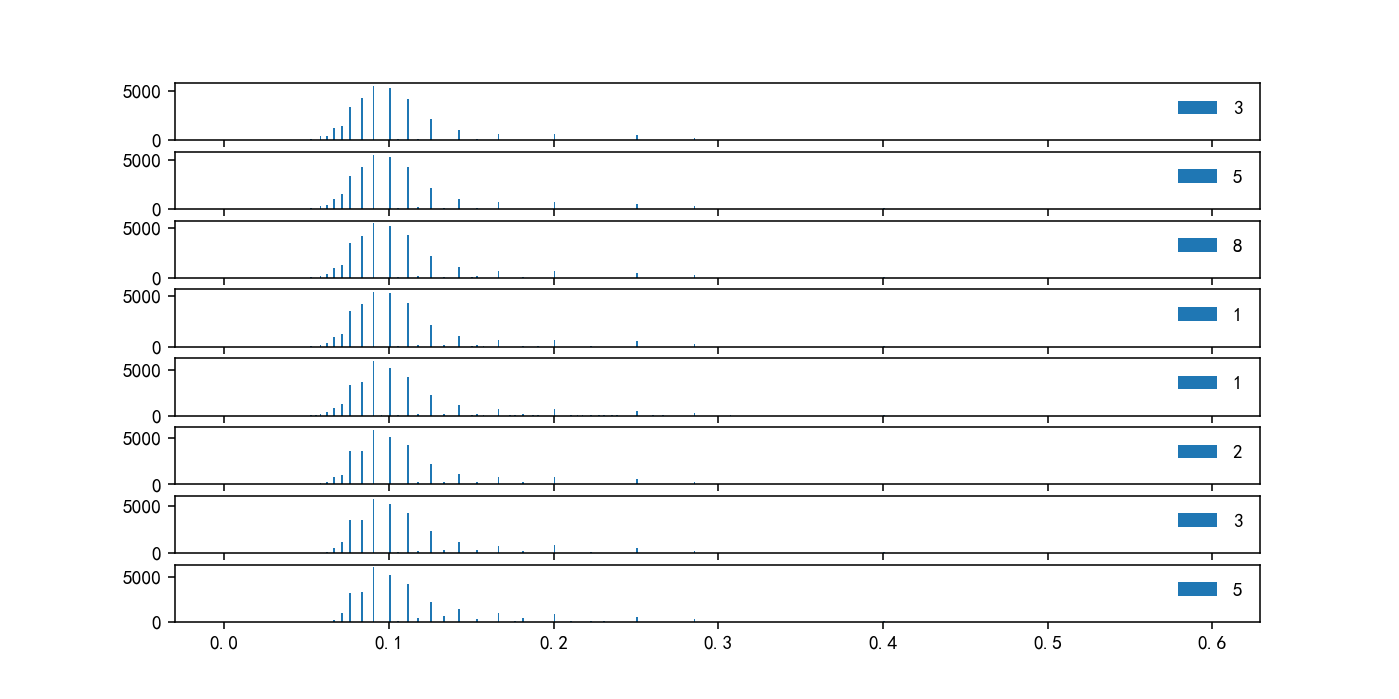

In [10]:
min_samples=[3,5,8,10,15,20,30,50]
fig,axes=plt.subplots(len(min_samples),sharex=True)
for i,s in enumerate(min_samples):
    axes[i].hist(dist_sorted[:,s],bins=np.arange(0,0.6,0.001));
    axes[i].legend('%s'%s,loc='best')

In [19]:
import sklearn.cluster as cluster
eps=0.1
min_samples=3
labels=cluster.DBSCAN(eps,min_samples,metric='precomputed').fit(dist_completed).labels_

In [20]:
for l in set(labels):
    print l,sum(labels==l)

0 9306
1 239
2 2755
3 1289
4 244
5 519
6 665
7 3408
8 437
9 154
10 55
11 70
12 315
13 76
14 602
15 221
16 60
17 54
18 84
19 85
20 78
21 92
22 58
23 73
24 59
25 1
26 51
27 94
28 65
29 1
30 10
31 1
32 1
33 38
34 54
35 1
36 1
37 1
38 1
39 1
40 1
41 9
42 1
43 32
44 30
45 1
46 1
47 1
48 1
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 30
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
-1 10993


In [32]:
trace_completed[labels==-1].path

4                                               56214BDCE
9                                                  7CDC7E
15                                                   CDCE
17                                    79A.03030826280A97E
18                                            56.21.4DC7E
19                                          56.2.108.265E
22                                             9A.014BDCE
23                                             56.2.14DCE
28                               9A0.30.8030.8.2.1.4BDC7E
30                                               79.A9.7E
32                       7C.D.B.4.1.082.1.41.2.8.0.A.9.7E
34                                            9A.0.1.4DCE
39       79.A.0.1.2.80.1.2.62.1.0.82.1.0.308.2.1.4.B.DC7E
44                                              CD.BD.C7E
48                       CD.B.4.1.0.8.280.30A0.1.4.D.C.7E
57                                          CD.B4.1.0.A9E
60                                              5628.0A9E
67            